In [1]:
from sklearn.datasets import fetch_openml

import matplotlib.pyplot as plt
import math, functools, time
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization

from scipy import stats




Download the MNIST_784 character dataset.

In [2]:
mnist = fetch_openml('mnist_784', version=1)

X, y = mnist["data"].values, mnist["target"].values
X = X/255

Display some random images for reference.

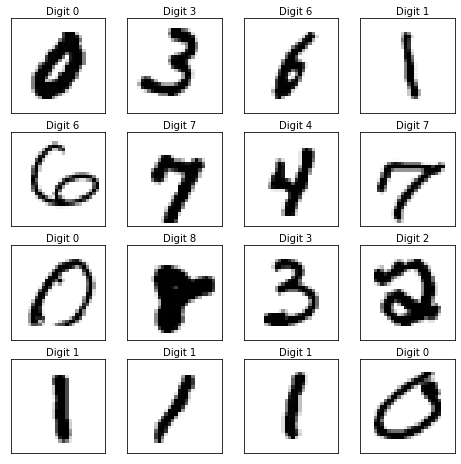

In [3]:
def display_sample(images, labels):
    samples = np.random.randint(0, images.shape[0], 16)
    random_images = images[samples,...]
    random_labels = labels[samples]
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))

    for i, (image, label) in enumerate(zip(random_images, random_labels)):
        axes[math.floor(i/4), i % 4].imshow(np.squeeze(image).reshape(28,28), cmap="binary")
        axes[math.floor(i/4), i % 4].get_xaxis().set_visible(False)
        axes[math.floor(i/4), i % 4].get_yaxis().set_visible(False)
        axes[math.floor(i/4), i % 4].text(10., -1.5, f'Digit {label}')
    
    plt.show()

display_sample(X, y)

The y data (labels) contains strings, but integers are more convenient, so we change the datatype.

In [4]:
print(type(X[0]))
print(type(y[0]))

y= y.astype(np.uint8)

print(type(y[0]))

<class 'numpy.ndarray'>
<class 'str'>
<class 'numpy.uint8'>


Set a random state for repeatable output

In [5]:
random_state = 0

We divide the dataset into three pieces: training, validation and testing. The testing data will be used after models have been developed using training and validation data.

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state = random_state, test_size = 0.2)

X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp, random_state = random_state,  test_size = 0.5)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(56000, 784)
(7000, 784)
(7000, 784)


A decorator function for displaying run times (e.g. for training and evaluation).

In [7]:
def timer(f):
    @functools.wraps(f)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        value = f(*args, **kwargs)
        duration = time.time() - start_time
        print("Run time :{:.3f}".format(duration))
        return value, duration
    return wrapper

Convenience functions for testing performance of most of the classifiers we will create.

In [8]:
@timer
def evaluator(X, y, classifier, logits = False):
    predictions = classifier.predict(X)
    if logits:
        predictions = np.argmax(predictions, axis = 1)
    acc = accuracy_score(predictions, y)
    pre = precision_score(predictions, y, average = 'macro')
    rec = recall_score(predictions, y, average = 'macro')
    con = confusion_matrix(predictions, y)
    return [acc, pre, rec, con]

def print_eval(acc, pre, rec, con):
    print(f'Accuracy: {acc}')
    print(f'Precision (macro): {pre}')
    print(f'Recall (macro): {rec}')
    plt.matshow(con, cmap=plt.cm.Greens)
    plt.show()
    print(con)
 

We will also maintain a dataframe of results.

In [9]:
columns = ['classifier', 'metric', 'baseline', 'k-preprocessing', 'small dataset', 'small dataset (k)', 'propagation (full)', 'propagation (80%)', 'propagation (20%)']
df = pd.DataFrame(columns = columns)
display(df)

,classifier,metric,baseline,k-preprocessing,small dataset,small dataset (k),propagation (full),propagation (80%),propagation (20%)


In [10]:
def update_df(df, classifier, column, train_duration, test_duration, values, append_mode = True, training_time = True):
    if append_mode:
        if training_time:
            df = df.append({'classifier' : classifier, 'metric' : 'train duration', column : train_duration}, ignore_index = True)
        df = df.append({'classifier' : classifier, 'metric' : 'test duration', column : test_duration}, ignore_index = True)
        df = df.append({'classifier' : classifier, 'metric' : 'accuracy', column : values[0]}, ignore_index = True)
        df = df.append({'classifier' : classifier, 'metric' : 'precision (macro)', column : values[1]}, ignore_index = True)
        df = df.append({'classifier' : classifier, 'metric' : 'recall (macro)', column : values[2]}, ignore_index = True)
    else:
        if training_time: 
            df.loc[(classifier, 'train duration')][column] = train_duration
        df.loc[(classifier, 'test duration')][column] = test_duration
        df.loc[(classifier, 'accuracy')][column] = values[0]
        df.loc[(classifier, 'precision (macro)')][column] = values[1]
        df.loc[(classifier, 'recall (macro)')][column] = values[2]
    return df

### Baseline models (full training set)

First we create a range of standard classifiers and train them on the training data. The classifiers used are:
* Logistic regression
* SVM
* A basic ANN architecture (not convolutional).
* A small CNN.

#### Logistic regression

In [11]:
log_reg_base = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=1, max_iter = 1000)

start_time = time.time()
log_reg_base.fit(X_train, y_train)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Training time :590.331


Run time :0.073
Accuracy: 0.9162857142857143
Precision (macro): 0.9153943408344052
Recall (macro): 0.9153189206316886


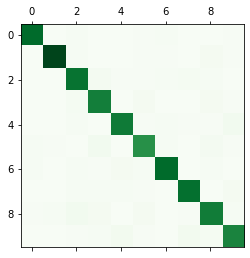

[[669   0   6   1   1   5   9   1   1   5]
 [  0 764   9   2   1   4   4   1  17   3]
 [  2   2 646  19   5   3   9  13   7   1]
 [  2   2  12 613   1  17   1   1  15   5]
 [  0   1   7   0 624   3   9   5   4  27]
 [ 11   3   2  27   1 558  11   0  20   5]
 [  7   0   8   3  15   8 669   0   9   0]
 [  0   1   6  10   8   4   1 656   2  16]
 [  4   6  29  17   2  16   2   5 620   7]
 [  0   1   3   6  24   3   0  26  14 595]]


In [12]:
values, test_duration = evaluator(X_val, y_val, log_reg_base)
print_eval(*values)

In [13]:
df = update_df(df, 'Logistic Regression', 'baseline', train_duration, test_duration, values)
display(df)

,classifier,metric,baseline,k-preprocessing,small dataset,small dataset (k),propagation (full),propagation (80%),propagation (20%)
0,Logistic Regression,train duration,590.330607,NaN,NaN,NaN,NaN,NaN,NaN
1,Logistic Regression,test duration,0.073017,NaN,NaN,NaN,NaN,NaN,NaN
2,Logistic Regression,accuracy,0.916286,NaN,NaN,NaN,NaN,NaN,NaN
3,Logistic Regression,precision (macro),0.915394,NaN,NaN,NaN,NaN,NaN,NaN
4,Logistic Regression,recall (macro),0.915319,NaN,NaN,NaN,NaN,NaN,NaN


#### SVM

In [14]:
svm_base = SVC()

start_time = time.time()
svm_base.fit(X_train, y_train)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Training time :270.057


Run time :95.242
Accuracy: 0.9772857142857143
Precision (macro): 0.9770326500659694
Recall (macro): 0.9772147629240493


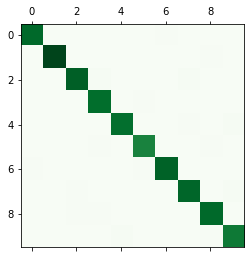

[[687   0   1   0   1   0   5   0   0   1]
 [  0 775   2   0   0   1   1   2   6   1]
 [  1   1 711  10   1   2   1   8   2   0]
 [  0   1   1 675   0   4   0   0   3   3]
 [  0   1   3   0 668   1   2   4   1   7]
 [  1   0   0   5   1 607   3   0   4   3]
 [  4   0   0   0   2   4 702   0   1   0]
 [  0   2   4   2   1   0   0 692   0   8]
 [  2   0   6   6   0   2   1   0 686   3]
 [  0   0   0   0   8   0   0   2   6 638]]


In [15]:
values, test_duration = evaluator(X_val, y_val, svm_base)
print_eval(*values)

In [16]:
df = update_df(df, 'SVM', 'baseline', train_duration, test_duration, values)
display(df)

,classifier,metric,baseline,k-preprocessing,small dataset,small dataset (k),propagation (full),propagation (80%),propagation (20%)
0,Logistic Regression,train duration,590.330607,NaN,NaN,NaN,NaN,NaN,NaN
1,Logistic Regression,test duration,0.073017,NaN,NaN,NaN,NaN,NaN,NaN
2,Logistic Regression,accuracy,0.916286,NaN,NaN,NaN,NaN,NaN,NaN
3,Logistic Regression,precision (macro),0.915394,NaN,NaN,NaN,NaN,NaN,NaN
4,Logistic Regression,recall (macro),0.915319,NaN,NaN,NaN,NaN,NaN,NaN
5,SVM,train duration,270.056741,NaN,NaN,NaN,NaN,NaN,NaN
6,SVM,test duration,95.242315,NaN,NaN,NaN,NaN,NaN,NaN
7,SVM,accuracy,0.977286,NaN,NaN,NaN,NaN,NaN,NaN
8,SVM,precision (macro),0.977033,NaN,NaN,NaN,NaN,NaN,NaN
9,SVM,recall (macro),0.977215,NaN,NaN,NaN,NaN,NaN,NaN


#### Basic ANN

In [17]:
def build_ann():
    model = Sequential([
        Dense(128, activation = 'relu', input_shape = (784,), kernel_regularizer = regularizers.l2(0.0001)),
        BatchNormalization(momentum = 0.9),
        Dropout(0.2),
        Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.0001)),
        BatchNormalization(momentum = 0.9),
        Dropout(0.2),
        Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.0001)),
        BatchNormalization(momentum = 0.9),
        Dropout(0.2),
        Dense(10, activation = 'softmax')
    ])
    model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc','mae'])
    return model

ann_base = build_ann()
print(ann_base.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1

In [18]:
stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=0, 
                         mode='auto', baseline=None)

In [19]:
start_time = time.time()
history = ann_base.fit(X_train, y_train, epochs=30, 
                    callbacks = [stopping], validation_data=(X_val, y_val), batch_size = 32, verbose = True)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Epoch 1/30
1750/1750 [==============================] - 20s 10ms/step - loss: 0.4344 - acc: 0.8798 - mae: 4.3773 - val_loss: 0.1996 - val_acc: 0.9499 - val_mae: 4.3566
Epoch 2/30
1750/1750 [==============================] - 18s 10ms/step - loss: 0.2620 - acc: 0.9344 - mae: 4.3773 - val_loss: 0.1666 - val_acc: 0.9639 - val_mae: 4.3566
Epoch 3/30
1750/1750 [==============================] - 18s 10ms/step - loss: 0.2327 - acc: 0.9452 - mae: 4.3773 - val_loss: 0.1543 - val_acc: 0.9676 - val_mae: 4.3566
Epoch 4/30
1750/1750 [==============================] - 17s 10ms/step - loss: 0.2131 - acc: 0.9518 - mae: 4.3773 - val_loss: 0.1567 - val_acc: 0.9694 - val_mae: 4.3566
Epoch 5/30
1750/1750 [==============================] - 18s 10ms/step - loss: 0.2055 - acc: 0.9547 - mae: 4.3773 - val_loss: 0.1551 - val_acc: 0.9693 - val_mae: 4.3566
Epoch 6/30
1750/1750 [==============================] - 18s 10ms/step - loss: 0.1951 - acc: 0.9588 - mae: 4.3773 - val_loss: 0.1525 - val_acc: 0.9714 - val_mae:

Run time :0.664
Accuracy: 0.9755714285714285
Precision (macro): 0.9754623922473364
Recall (macro): 0.975390271920384


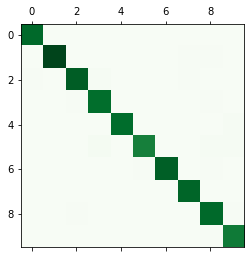

[[683   0   2   1   1   0   2   0   1   3]
 [  0 771   1   0   0   0   0   4   6   0]
 [  4   2 708  11   1   1   1   6   1   1]
 [  0   1   5 669   0   2   0   1   4   3]
 [  2   0   1   0 673   0   1   0   1  10]
 [  2   0   1  13   0 613   3   1   7   7]
 [  3   1   1   0   3   4 707   1   4   0]
 [  0   2   3   3   0   0   0 692   0   3]
 [  1   3   6   1   1   0   1   1 681   5]
 [  0   0   0   0   3   1   0   2   4 632]]


In [20]:
values, test_duration = evaluator(X_val, y_val, ann_base, logits = True)
print_eval(*values)

In [21]:
df = update_df(df, 'ANN', 'baseline', train_duration, test_duration, values)
display(df)

,classifier,metric,baseline,k-preprocessing,small dataset,small dataset (k),propagation (full),propagation (80%),propagation (20%)
0,Logistic Regression,train duration,590.330607,NaN,NaN,NaN,NaN,NaN,NaN
1,Logistic Regression,test duration,0.073017,NaN,NaN,NaN,NaN,NaN,NaN
2,Logistic Regression,accuracy,0.916286,NaN,NaN,NaN,NaN,NaN,NaN
3,Logistic Regression,precision (macro),0.915394,NaN,NaN,NaN,NaN,NaN,NaN
4,Logistic Regression,recall (macro),0.915319,NaN,NaN,NaN,NaN,NaN,NaN
5,SVM,train duration,270.056741,NaN,NaN,NaN,NaN,NaN,NaN
6,SVM,test duration,95.242315,NaN,NaN,NaN,NaN,NaN,NaN
7,SVM,accuracy,0.977286,NaN,NaN,NaN,NaN,NaN,NaN
8,SVM,precision (macro),0.977033,NaN,NaN,NaN,NaN,NaN,NaN
9,SVM,recall (macro),0.977215,NaN,NaN,NaN,NaN,NaN,NaN


#### CNN

In [22]:
# We must reshape the X data into being 28x28 blocks rather than lists 728 elements long
# We must also add an extra 'btach' dimension to comply with tensorflow sytnax

X_cnn_train = np.array([x.reshape(28,28) for x in X_train])
X_cnn_train = np.expand_dims(X_cnn_train,-1)

X_cnn_val = np.array([x.reshape(28,28) for x in X_val])
X_cnn_val = np.expand_dims(X_cnn_val,-1)

X_cnn_test = np.array([x.reshape(28,28) for x in X_test])
X_cnn_test = np.expand_dims(X_cnn_test,-1)

In [23]:
print(X_cnn_train.shape)

(56000, 28, 28, 1)


In [24]:
def build_cnn():
    model = Sequential([
        Conv2D(64, 3, activation = 'relu', input_shape = (28,28,1)),
        MaxPooling2D(2),
        BatchNormalization(momentum = 0.9),
        Conv2D(64, 3, activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(momentum = 0.9),
        Conv2D(32, 3, activation = 'relu'),
        MaxPooling2D(2),
        Flatten(),
        Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(10, activation = 'softmax')
    ])
    model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc','mae'])
    return model

cnn_base = build_cnn()
print(cnn_base.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 5, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 32)         

In [25]:
start_time = time.time()
history = cnn_base.fit(X_cnn_train, y_train, validation_data=(X_cnn_val, y_val), epochs=30, 
                    callbacks = [stopping], batch_size = 32, verbose = True)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Epoch 1/30
1750/1750 [==============================] - 18s 8ms/step - loss: 0.2139 - acc: 0.9474 - mae: 4.3773 - val_loss: 0.1044 - val_acc: 0.9793 - val_mae: 4.3566
Epoch 2/30
1750/1750 [==============================] - 14s 8ms/step - loss: 0.0978 - acc: 0.9787 - mae: 4.3773 - val_loss: 0.0865 - val_acc: 0.9821 - val_mae: 4.3566
Epoch 3/30
1750/1750 [==============================] - 14s 8ms/step - loss: 0.0717 - acc: 0.9843 - mae: 4.3773 - val_loss: 0.0753 - val_acc: 0.9839 - val_mae: 4.3566
Epoch 4/30
1750/1750 [==============================] - 14s 8ms/step - loss: 0.0604 - acc: 0.9862 - mae: 4.3773 - val_loss: 0.0575 - val_acc: 0.9867 - val_mae: 4.3566
Epoch 5/30
1750/1750 [==============================] - 14s 8ms/step - loss: 0.0506 - acc: 0.9880 - mae: 4.3773 - val_loss: 0.0627 - val_acc: 0.9833 - val_mae: 4.3566
Epoch 6/30
1750/1750 [==============================] - 14s 8ms/step - loss: 0.0436 - acc: 0.9903 - mae: 4.3773 - val_loss: 0.0686 - val_acc: 0.9837 - val_mae: 4.356

Run time :0.590
Accuracy: 0.9854285714285714
Precision (macro): 0.9854009614396393
Recall (macro): 0.9852762468233097


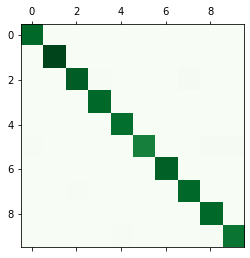

[[686   0   1   0   0   0   3   1   0   2]
 [  1 777   1   0   2   1   0   3   2   2]
 [  0   0 716   4   2   1   0  10   1   0]
 [  0   0   1 690   0   1   0   0   0   0]
 [  0   0   0   0 669   0   0   0   2   2]
 [  4   0   1   3   0 618   3   3   8   7]
 [  3   0   0   0   1   0 708   0   0   0]
 [  0   3   4   0   2   0   0 691   0   0]
 [  1   0   3   1   0   0   0   0 692   0]
 [  0   0   1   0   6   0   1   0   4 651]]


In [26]:
values, test_duration = evaluator(X_cnn_val, y_val, cnn_base, logits = True)
print_eval(*values)

In [27]:
df = update_df(df, 'CNN', 'baseline', train_duration, test_duration, values)
display(df)

,classifier,metric,baseline,k-preprocessing,small dataset,small dataset (k),propagation (full),propagation (80%),propagation (20%)
0,Logistic Regression,train duration,590.330607,NaN,NaN,NaN,NaN,NaN,NaN
1,Logistic Regression,test duration,0.073017,NaN,NaN,NaN,NaN,NaN,NaN
2,Logistic Regression,accuracy,0.916286,NaN,NaN,NaN,NaN,NaN,NaN
3,Logistic Regression,precision (macro),0.915394,NaN,NaN,NaN,NaN,NaN,NaN
4,Logistic Regression,recall (macro),0.915319,NaN,NaN,NaN,NaN,NaN,NaN
5,SVM,train duration,270.056741,NaN,NaN,NaN,NaN,NaN,NaN
6,SVM,test duration,95.242315,NaN,NaN,NaN,NaN,NaN,NaN
7,SVM,accuracy,0.977286,NaN,NaN,NaN,NaN,NaN,NaN
8,SVM,precision (macro),0.977033,NaN,NaN,NaN,NaN,NaN,NaN
9,SVM,recall (macro),0.977215,NaN,NaN,NaN,NaN,NaN,NaN


#### Comparison

Logistic regression performs worst, with accuracy metrics around 92% (still fairly decent) and a relatively long training time (though fast testing time). SVM is faster to train, but has relatively poor testing time, though improved metrics up at around 98%. The ANN performs well, being relatively fast in training and testing, and with metrics up around 98%. The best however is CNN (as might be expected), which is fastest in training, 2nd fastest in testing, and with the best metrics at around 98.5%. 

#### Voting ensemble

In [28]:
def classify(X, classifiers = None, ann_classifiers = None, cnn_classifiers = None):
    predictions = []
    for c in classifiers:
        predictions.append(c.predict(X))
    for ann in ann_classifiers:
        predictions.append(np.argmax(ann.predict(X), axis = 1))    
    X_cnn = np.array([x.reshape(28,28) for x in X])
    X_cnn = np.expand_dims(X_cnn,-1)
    for cnn in cnn_classifiers:
        predictions.append(np.argmax(cnn.predict(X_cnn), axis = 1))
    return stats.mode(predictions)[0][0]
    
    

In [29]:
classifiers = [log_reg_base, svm_base]
ann_classifiers = [ann_base]
cnn_classifiers = [cnn_base]

start_time = time.time()
ensemble_predictions_val = classify(X_val, classifiers, ann_classifiers, cnn_classifiers)
test_duration = time.time() - start_time
print("Testing time :{:.3f}".format(test_duration))
print(ensemble_predictions_val[0:5])

Testing time :96.270
[4 5 3 7 6]


Accuracy: 0.9801428571428571
Precision (macro): 0.979815841301216
Recall (macro): 0.9801780877043085


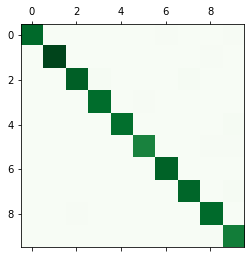

[[690   0   2   1   1   0   4   0   0   4]
 [  0 779   2   0   1   1   1   2   6   2]
 [  1   0 715   9   2   1   1  10   2   1]
 [  0   0   2 681   0   4   0   0   3   3]
 [  0   0   1   0 674   1   1   1   1  10]
 [  2   0   0   3   0 611   3   0   5   6]
 [  2   0   0   0   0   2 704   0   2   0]
 [  0   1   2   2   1   0   0 695   0   8]
 [  0   0   4   2   0   1   1   0 685   3]
 [  0   0   0   0   3   0   0   0   5 627]]


In [30]:
values = []
values.append(accuracy_score(ensemble_predictions_val, y_val))
values.append(precision_score(ensemble_predictions_val, y_val, average = 'macro'))
values.append(recall_score(ensemble_predictions_val, y_val, average = 'macro'))
values.append(confusion_matrix(ensemble_predictions_val, y_val))

print(f'Accuracy: {values[0]}')
print(f'Precision (macro): {values[1]}')
print(f'Recall (macro): {values[2]}')
plt.matshow(values[3], cmap=plt.cm.Greens)
plt.show()
print(values[3])

In [31]:
df = update_df(df, 'Voting Ensemble', 'baseline', np.nan, test_duration, values)
#display(df)

In [32]:
df = df.set_index(['classifier', 'metric'])
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607              NaN   
                    test duration        0.073017              NaN   
                    accuracy             0.916286              NaN   
                    precision (macro)    0.915394              NaN   
                    recall (macro)       0.915319              NaN   
SVM                 train duration     270.056741              NaN   
                    test duration       95.242315              NaN   
                    accuracy             0.977286              NaN   
                    precision (macro)    0.977033              NaN   
                    recall (macro)       0.977215              NaN   
ANN                 train duration     428.135511              NaN   
                    test duration        0.664342              NaN   
                    accuracy             0.975571              NaN   
                    precision (macro)    0.975462              NaN   
                    recall (macro)       0.975390              NaN   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
SVM                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
ANN                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
CNN                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   

                                       propagation (full)  propagation (80%)  \
classifier          metric                  

### Models with kmeans preprocessing 

In his book 'Hands on Machine Learning with Scikit-Learn, Keras and Tensorflow', Geron suggests using K-means as a preprocessing/dimensionality reduction step as a possible way to improve performance on these kinds of tasks (see Chapter 9). Here we will test this for logistic regression, SVM and our ANN (it doesn't make sense for CNN).

In [33]:
k = 100

kmeans = KMeans(n_clusters = k, random_state = random_state )

start_time = time.time()
kmeans.fit(X_train,y_train)
print("Training time :{:.3f}".format(time.time() - start_time))

start_time = time.time()
X_train_k = kmeans.transform(X_train)
print("Transform time :{:.3f}".format(time.time() - start_time))

X_val_k = kmeans.transform(X_val)

Training time :403.895
Transform time :3.946


#### Logistic regression

In [34]:
#from sklearn.pipeline import Pipeline
#from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=1, max_iter = 3000)


start_time = time.time()
log_reg.fit(X_train_k, y_train)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Training time :401.086


C:\Users\Rob\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Run time :0.023
Accuracy: 0.9321428571428572
Precision (macro): 0.9311661908767219
Recall (macro): 0.9312861573101499


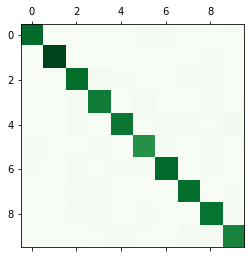

[[674   0   2   0   1   6   6   0   0   3]
 [  0 767   3   2   0   2   2   4   9   2]
 [  2   3 666  20   7   4   5  12   8   0]
 [  2   0   7 625   0  17   1   2  11   4]
 [  0   2  12   0 638   5   8   6   4  26]
 [  6   3   3  20   0 559  13   1  12   4]
 [  7   0   9   3   9  10 676   1   6   0]
 [  0   3   9  13   2   1   0 665   0  13]
 [  2   1  15  11   2  12   4   2 650   7]
 [  2   1   2   4  23   5   0  15   9 605]]


In [35]:
values, test_duration = evaluator(X_val_k, y_val, log_reg)
print_eval(*values)

In [36]:
df = update_df(df, 'Logistic Regression', 'k-preprocessing', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741              NaN   
                    test duration       95.242315              NaN   
                    accuracy             0.977286              NaN   
                    precision (macro)    0.977033              NaN   
                    recall (macro)       0.977215              NaN   
ANN                 train duration     428.135511              NaN   
                    test duration        0.664342              NaN   
                    accuracy             0.975571              NaN   
                    precision (macro)    0.975462              NaN   
                    recall (macro)       0.975390              NaN   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
SVM                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
ANN                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
CNN                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   

                                       propagation (full)  propagation (80%)  \
classifier          metric                  

We get a small improvement to the metrics (around 2 percentage points). The training is faster, but not if we include the training time for k-means.

#### SVM

In [37]:
svm = SVC()

start_time = time.time()
svm.fit(kmeans.transform(X_train), y_train)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Training time :72.480


Run time :18.095
Accuracy: 0.958
Precision (macro): 0.9575113793129336
Recall (macro): 0.9575830699434746


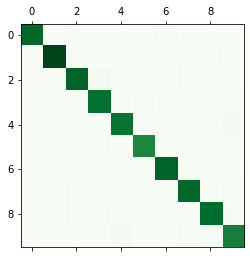

[[681   0   5   0   0   2   7   0   0   2]
 [  0 770   2   1   0   1   1   4   8   1]
 [  3   1 693  17   5   3   2   8   3   0]
 [  2   5   3 656   0   9   1   1   6   6]
 [  1   1   3   0 650   2   4   3   4  17]
 [  3   0   3   8   0 595   6   2   5   5]
 [  3   0   2   0   5   4 693   0   2   0]
 [  0   2   7   5   2   0   0 682   2   9]
 [  2   0   9   9   2   4   1   0 671   9]
 [  0   1   1   2  18   1   0   8   8 615]]


In [38]:
values, test_duration = evaluator(X_val_k, y_val, svm)
print_eval(*values)

In [39]:
df = update_df(df, 'SVM', 'k-preprocessing', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511              NaN   
                    test duration        0.664342              NaN   
                    accuracy             0.975571              NaN   
                    precision (macro)    0.975462              NaN   
                    recall (macro)       0.975390              NaN   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
SVM                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
ANN                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
CNN                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   

                                       propagation (full)  propagation (80%)  \
classifier          metric                  

Performace metrics are slightly worse here. Training time is reduced, but again not if we include the trainign time for k-means.

#### ANN

In [40]:
def build_ann_k():
    model = Sequential([
        Dense(128, activation = 'relu', input_shape = (k,), kernel_regularizer = regularizers.l2(0.0001)),
        BatchNormalization(momentum = 0.9),
        Dropout(0.2),
        Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.0001)),
        BatchNormalization(momentum = 0.9),
        Dropout(0.2),
        Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.0001)),
        BatchNormalization(momentum = 0.9),
        Dropout(0.2),
        Dense(10, activation = 'softmax')
    ])
    model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc','mae'])
    return model

ann = build_ann_k()
print(ann.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               12928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [41]:
start_time = time.time()
history = ann.fit(X_train_k, y_train, epochs=30, 
                    callbacks = [stopping], validation_data=(X_val_k, y_val), batch_size = 32, verbose = True)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Epoch 1/30
1750/1750 [==============================] - 19s 10ms/step - loss: 0.5747 - acc: 0.8260 - mae: 4.3773 - val_loss: 0.5388 - val_acc: 0.8304 - val_mae: 4.3566
Epoch 2/30
1750/1750 [==============================] - 18s 10ms/step - loss: 0.4503 - acc: 0.8660 - mae: 4.3773 - val_loss: 0.5858 - val_acc: 0.8367 - val_mae: 4.3566
Epoch 3/30
1750/1750 [==============================] - 18s 10ms/step - loss: 0.4279 - acc: 0.8725 - mae: 4.3773 - val_loss: 0.5610 - val_acc: 0.8340 - val_mae: 4.3566
Epoch 4/30
1750/1750 [==============================] - 18s 10ms/step - loss: 0.4455 - acc: 0.8674 - mae: 4.3773 - val_loss: 0.8960 - val_acc: 0.7173 - val_mae: 4.3566
Epoch 5/30
1750/1750 [==============================] - 18s 10ms/step - loss: 0.4184 - acc: 0.8753 - mae: 4.3773 - val_loss: 0.6801 - val_acc: 0.7999 - val_mae: 4.3566
Epoch 6/30
1750/1750 [==============================] - 18s 10ms/step - loss: 0.4292 - acc: 0.8707 - mae: 4.3773 - val_loss: 0.3680 - val_acc: 0.8927 - val_mae:

Run time :0.599
Accuracy: 0.8111428571428572
Precision (macro): 0.8038208000433125
Recall (macro): 0.8439888344047599


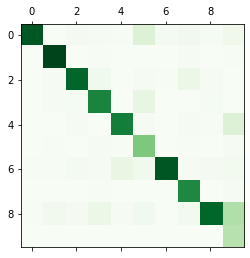

[[685   1  17   9   5 116  19  29  12  40]
 [  0 729   1   4   0   2   0   9   2   5]
 [  1   8 652  37   2   6   4  62  10   1]
 [  1   6  13 569   0  78   2   1  13   1]
 [  0   0   8   0 585  10   1   7   5 119]
 [  1   3   0   9   3 343   1   5   1   7]
 [  4   3  19   6  75  34 687   9  16  24]
 [  0   0   2   5   1   0   0 558   0  11]
 [  3  30  16  59  11  32   1  27 650 236]
 [  0   0   0   0   0   0   0   1   0 220]]


In [42]:
values, test_duration = evaluator(X_val_k, y_val, ann, logits = True)
print_eval(*values)

In [43]:
df = update_df(df, 'ANN', 'k-preprocessing', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
SVM                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
ANN                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
CNN                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   

                                       propagation (full)  propagation (80%)  \
classifier          metric                  

Performance is significantly worse here.

### Baseline models (small training set)

How do our models perform in the case where we have only a very small amount of labeled training data? To investigate this we will train our models on 0.1% of the training data (56 data points). These 56 points are sampled randomly, but stratification is used to ensure appropriate class proportions (this is not entirely realistic, as without a large labeled dataset we don't know what the class proportions are, but it removes a source of randomness from the tests).

In [44]:
X_small, X_temp, y_small, y_temp = train_test_split(X_train, y_train, train_size = 0.001, stratify = y_train)
print(X_small.shape)

(56, 784)


#### Logistic regression

In [45]:
log_reg_small = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=1, max_iter = 1000)

start_time = time.time()
log_reg_small.fit(X_small, y_small)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Training time :0.188


Run time :0.067
Accuracy: 0.6552857142857142
Precision (macro): 0.6504948405193631
Recall (macro): 0.6662498129641662


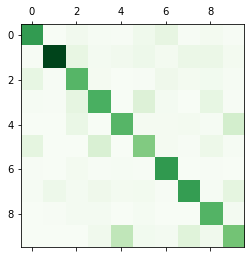

[[496   0  30   6   3  39  81   5  20   4]
 [  3 722  75  17  30  46  20  57  58  22]
 [ 78   4 412  15   2   5  40  22  26  10]
 [ 11   5  86 436   2 113  18   0  77   5]
 [  1   0  63   1 413  16  16  22  11 143]
 [ 88   0   2 125   2 333  16   4  48  10]
 [  5   0  22   4  11   4 502   0   3   0]
 [ 11  46  17  41  22  24   3 490  11  89]
 [  1   3  19  19   2  13   2   2 420  18]
 [  1   0   2  34 195  28  17 106  35 363]]


In [46]:
values, test_duration = evaluator(X_val, y_val, log_reg_small)
print_eval(*values)

In [47]:
df = update_df(df, 'Logistic Regression', 'small dataset', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960                NaN   
                    test duration           0.066587                NaN   
                    accuracy                0.655286                NaN   
                    precision (macro)       0.650495                NaN   
                    recall (macro)          0.666250                NaN   
SVM                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
ANN                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
CNN                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   

                                       propagation (full)  propagation (80%)  \
classifier          metric                  

#### SVM

In [48]:
svm_small = SVC()

start_time = time.time()
svm_small.fit(X_small, y_small)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Training time :0.007


Run time :0.416
Accuracy: 0.6205714285714286
Precision (macro): 0.6122408532368195
Recall (macro): 0.6889353222522355


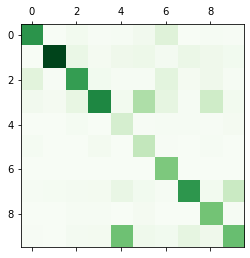

[[531   0  25   4   6  32 113   0   9   3]
 [  1 746  65  17  42  51  19  59  42  29]
 [104   4 507  28   9  10  98  17  43   7]
 [ 30  16  76 571  26 245  86   6 162  24]
 [  0   0  12   0 142   3   9  10   3  17]
 [ 14   0   0  23   0 198   3   0   7   2]
 [  1   0   0   0   1   1 353   0   0   0]
 [  9  14  18  23  71  27   7 526  26 176]
 [  0   0   6  11   1  15   0   0 375  11]
 [  5   0  19  21 384  39  27  90  42 395]]


In [49]:
values, test_duration = evaluator(X_val, y_val, svm_small)
print_eval(*values)

In [50]:
df = update_df(df, 'SVM', 'small dataset', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960                NaN   
                    test duration           0.066587                NaN   
                    accuracy                0.655286                NaN   
                    precision (macro)       0.650495                NaN   
                    recall (macro)          0.666250                NaN   
SVM                 train duration          0.006994                NaN   
                    test duration           0.416207                NaN   
                    accuracy                0.620571                NaN   
                    precision (macro)       0.612241                NaN   
                    recall (macro)          0.688935                NaN   
ANN                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
CNN                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   

                                       propagation (full)  propagation (80%)  \
classifier          metric                  

#### Basic ANN

In [51]:
# This ANN has more regulariztion, to try to compensate for minimal data

def build_reg_ann():
    model = Sequential([
        Dense(128, activation = 'relu', input_shape = (784,), kernel_regularizer = regularizers.l2(0.01)),
        BatchNormalization(momentum = 0.9),
        Dropout(0.4),
        Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)),
        BatchNormalization(momentum = 0.9),
        Dropout(0.4),
        Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)),
        BatchNormalization(momentum = 0.9),
        Dropout(0.4),
        Dense(10, activation = 'softmax')
    ])
    model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc','mae'])
    return model

ann_small = build_reg_ann()
print(ann.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               12928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [52]:
start_time = time.time()
history = ann_small.fit(X_small, y_small, epochs=30, 
                    callbacks = [stopping], validation_data=(X_val, y_val), batch_size = 32, verbose = True)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Epoch 1/30
2/2 [==============================] - 2s 1s/step - loss: 5.6757 - acc: 0.1250 - mae: 4.3321 - val_loss: 4.6560 - val_acc: 0.1307 - val_mae: 4.3566
Epoch 2/30
2/2 [==============================] - 1s 881ms/step - loss: 5.5230 - acc: 0.1071 - mae: 4.3321 - val_loss: 4.5645 - val_acc: 0.1359 - val_mae: 4.3566
Epoch 3/30
2/2 [==============================] - 1s 847ms/step - loss: 4.8232 - acc: 0.1786 - mae: 4.3321 - val_loss: 4.4814 - val_acc: 0.1451 - val_mae: 4.3566
Epoch 4/30
2/2 [==============================] - 1s 865ms/step - loss: 4.5090 - acc: 0.2500 - mae: 4.3321 - val_loss: 4.3896 - val_acc: 0.1524 - val_mae: 4.3566
Epoch 5/30
2/2 [==============================] - 1s 821ms/step - loss: 4.3044 - acc: 0.2679 - mae: 4.3321 - val_loss: 4.2938 - val_acc: 0.1709 - val_mae: 4.3566
Epoch 6/30
2/2 [==============================] - 1s 898ms/step - loss: 4.3956 - acc: 0.3393 - mae: 4.3321 - val_loss: 4.1961 - val_acc: 0.1894 - val_mae: 4.3566
Epoch 7/30
2/2 [===============

Run time :0.645
Accuracy: 0.5725714285714286
Precision (macro): 0.5655417749105074
Recall (macro): 0.6284591572577485


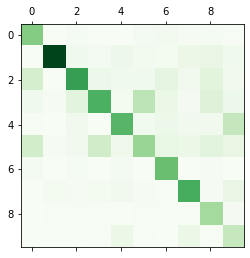

[[335   0  13   1   1  18  25   6  12   5]
 [  0 736  37  18  48  24  23  57  70  40]
 [143   2 497  52  39  33  89  30  98  30]
 [ 36   8  97 438  21 207  58  16 112  52]
 [  5   1  30   2 420  28  53  30  30 191]
 [153   8  29 156  42 292  74  59  96  75]
 [ 19   0  14   0  19   2 386   0   7   0]
 [  2  22   7  23  29  10   4 449  11  69]
 [  0   3   4   4   1   3   3   2 269  16]
 [  2   0   0   4  62   4   0  59   4 186]]


In [53]:
values, test_duration = evaluator(X_val, y_val, ann_small, logits = True)
print_eval(*values)


In [54]:
df = update_df(df, 'ANN', 'small dataset', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960                NaN   
                    test duration           0.066587                NaN   
                    accuracy                0.655286                NaN   
                    precision (macro)       0.650495                NaN   
                    recall (macro)          0.666250                NaN   
SVM                 train duration          0.006994                NaN   
                    test duration           0.416207                NaN   
                    accuracy                0.620571                NaN   
                    precision (macro)       0.612241                NaN   
                    recall (macro)          0.688935                NaN   
ANN                 train duration         28.467634                NaN   
                    test duration           0.644927                NaN   
                    accuracy                0.572571                NaN   
                    precision (macro)       0.565542                NaN   
                    recall (macro)          0.628459                NaN   
CNN                 train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   

                                       propagation (full)  propagation (80%)  \
classifier          metric                  

#### Basic CNN

In [56]:
def build_reg_cnn():
    model = Sequential([
        Conv2D(64, 3, activation = 'relu', input_shape = (28,28,1)),
        MaxPooling2D(2),
        BatchNormalization(momentum = 0.9),
        Conv2D(64, 3, activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(momentum = 0.9),
        Conv2D(32, 3, activation = 'relu'),
        MaxPooling2D(2),
        Flatten(),
        Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)),
        Dropout(0.5),
        Dense(10, activation = 'softmax')
    ])
    model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc','mae'])
    return model

cnn_small = build_reg_cnn()
print(cnn_small.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 5, 5, 64)          256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 32)         

In [57]:
X_cnn_small = np.array([x.reshape(28,28) for x in X_small])
X_cnn_small = np.expand_dims(X_cnn_small,-1)
print(X_cnn_small.shape)
print(y_small)

(56, 28, 28, 1)
[3 4 4 3 4 6 7 5 0 3 2 7 2 9 5 1 0 5 4 3 2 2 9 6 8 5 3 1 9 6 6 7 1 6 9 5 0
 8 9 2 0 3 8 8 2 7 0 7 1 1 7 9 0 4 8 1]


In [58]:
start_time = time.time()
history = cnn_small.fit(X_cnn_small, y_small, validation_data=(X_cnn_val, y_val), epochs=100, 
                    callbacks = [], batch_size = 32, verbose = True)
train_duration
print("Training time :{:.3f}".format(train_duration))

Epoch 1/100
2/2 [==============================] - 2s 1s/step - loss: 3.0914 - acc: 0.1429 - mae: 4.3321 - val_loss: 2.8041 - val_acc: 0.1003 - val_mae: 4.3566
Epoch 2/100
2/2 [==============================] - 1s 912ms/step - loss: 2.5954 - acc: 0.2321 - mae: 4.3321 - val_loss: 2.7966 - val_acc: 0.1017 - val_mae: 4.3566
Epoch 3/100
2/2 [==============================] - 1s 871ms/step - loss: 2.5646 - acc: 0.2679 - mae: 4.3321 - val_loss: 2.7917 - val_acc: 0.1014 - val_mae: 4.3566
Epoch 4/100
2/2 [==============================] - 1s 885ms/step - loss: 2.4413 - acc: 0.3214 - mae: 4.3321 - val_loss: 2.7848 - val_acc: 0.1013 - val_mae: 4.3566
Epoch 5/100
2/2 [==============================] - 1s 814ms/step - loss: 2.0335 - acc: 0.5357 - mae: 4.3321 - val_loss: 2.7746 - val_acc: 0.1011 - val_mae: 4.3566
Epoch 6/100
2/2 [==============================] - 1s 887ms/step - loss: 1.9287 - acc: 0.6071 - mae: 4.3321 - val_loss: 2.7638 - val_acc: 0.1024 - val_mae: 4.3566
Epoch 7/100
2/2 [========

Run time :0.644
Accuracy: 0.7137142857142857
Precision (macro): 0.7094154535173935
Recall (macro): 0.7248383646413593


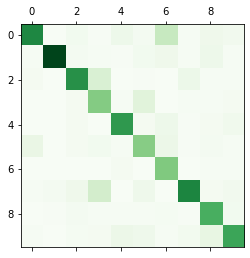

[[579   0  27   5  48  19 188  11  44  31]
 [  7 759  19  10   4  29  43   7  48   9]
 [ 17   0 553 131   2   5   2  56  11  11]
 [  0   0  17 346   7 107   2  11  11  16]
 [  2   0  16   1 530  16  50   3  17  35]
 [ 70   0  16  27   6 339  59   4  18   7]
 [  0   0   2   0  16   2 353   0   6   7]
 [ 10  18  44 152   0  47   0 585  15  30]
 [  0   3  20  11  11  11  12   5 461  27]
 [ 10   0  14  15  58  46   6  26  78 491]]


In [59]:
values, test_duration = evaluator(X_cnn_val, y_val, cnn_small, logits = True)
print_eval(*values)

In [60]:
df = update_df(df, 'CNN', 'small dataset', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960                NaN   
                    test duration           0.066587                NaN   
                    accuracy                0.655286                NaN   
                    precision (macro)       0.650495                NaN   
                    recall (macro)          0.666250                NaN   
SVM                 train duration          0.006994                NaN   
                    test duration           0.416207                NaN   
                    accuracy                0.620571                NaN   
                    precision (macro)       0.612241                NaN   
                    recall (macro)          0.688935                NaN   
ANN                 train duration         28.467634                NaN   
                    test duration           0.644927                NaN   
                    accuracy                0.572571                NaN   
                    precision (macro)       0.565542                NaN   
                    recall (macro)          0.628459                NaN   
CNN                 train duration         28.467634                NaN   
                    test duration           0.644274                NaN   
                    accuracy                0.713714                NaN   
                    precision (macro)       0.709415                NaN   
                    recall (macro)          0.724838                NaN   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   
                    accuracy                     NaN                NaN   
                    precision (macro)            NaN                NaN   
                    recall (macro)               NaN                NaN   

                                       propagation (full)  propagation (80%)  \
classifier          metric                  

#### Comparison

Performance for all classifiers is significantly worse, as might be excpected. Again CNN has the best performance overall.

### Training on small training sets using kmeans

We now consider the situation where we have a small training set, but where we have used k-means to find 'good' training data. We set the size of the training set to be 56, for comparison with the baseline models trained above, and we run k-means with 56 classes to identify 56 clusters in the original training set. For each cluster we identify the character closest to the centroid, and we manually label it (this method can be used when we start with unlabeled data). We then train our models on this manually labeled data. 

Geron suggests this method of 'semisupervised' learning can improve classifier performance over purely random training data (again in Chapter 9). 

In [61]:
k = 56

kmeans = KMeans(n_clusters = k, random_state = random_state)

start_time = time.time()
kmeans.fit(X_train,y_train)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Training time :245.495


In [62]:
X_train_classes = kmeans.transform(X_train)
representatives = np.argmin(X_train_classes, axis = 0)

X_reps = X_train[representatives]

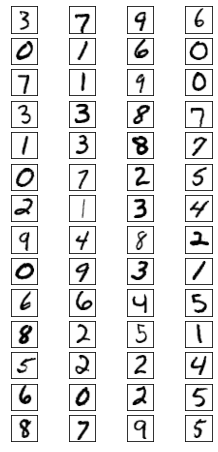

In [63]:
fig, axes = plt.subplots(14, 4, figsize=(4, 8))

for i, image in enumerate(X_reps):
    axes[math.floor(i/4), i % 4].imshow(np.squeeze(image).reshape(28,28), cmap="binary")
    axes[math.floor(i/4), i % 4].get_xaxis().set_visible(False)
    axes[math.floor(i/4), i % 4].get_yaxis().set_visible(False)
    
plt.show()

In [64]:
# This must be changed if random seed is changed from 0
y_reps = np.array(
    [3,7,9,6,
    0,1,6,0,
    7,1,9,0,
    3,3,8,7,
    1,3,8,7,
    0,7,2,5,
    2,1,3,4,
    9,4,8,2,
    0,9,3,1,
    6,6,4,5,
    8,2,5,1,
    5,2,2,4,
    6,0,2,5,
    8,7,9,5])
print(len(y_reps))

56


#### Baseline k-means

Since we have labeled the characters that are nearest to the cnetroids for each of the 56 k-means classes, we obtain a classifier simply by propogating these labels to every member of the class. This is our baseline k-means classifier to which all classifiers trained using the labeled 'centroid' data must be compared.

In [65]:
start_time = time.time()
predicted_val_classes = np.argmin(kmeans.transform(X_val),axis = 1)
y_predictions = []

for i in range(len(predicted_val_classes)):
    y_predictions.append(y_reps[predicted_val_classes[i]])

test_duration = time.time() - start_time    
y_predictions = np.array(y_predictions)    
print(y_predictions[:5])

[9 5 3 7 6]


Accuracy: 0.809
Precision (macro): 0.8053239185453043
Recall (macro): 0.8141674624973108


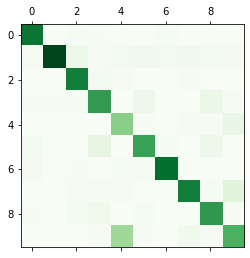

[[642   0  12   4   0   2  12   0   2   1]
 [  7 768  50  10  25  31  25  31  23  15]
 [  3   2 616  18   9   1   2  10   2   1]
 [  4   5   9 525   0  50   0   0  65   9]
 [  1   1   3   0 333   4   1  11   6  69]
 [ 18   1   1  86   1 507  13   1  48   1]
 [ 16   0   4   1  14   6 661   0   3   1]
 [  0   1  10   8  10   1   0 615  13 102]
 [  4   1  22  40   0  14   0   1 536   5]
 [  0   1   1   6 290   5   1  39  11 460]]


In [66]:
values = []
values.append(accuracy_score(y_predictions, y_val))
values.append(precision_score(y_predictions, y_val, average = 'macro'))
values.append(recall_score(y_predictions, y_val, average = 'macro'))
values.append(confusion_matrix(y_predictions, y_val))

print(f'Accuracy: {values[0]}')
print(f'Precision (macro): {values[1]}')
print(f'Recall (macro): {values[2]}')
plt.matshow(values[3], cmap=plt.cm.Greens)
plt.show()
print(values[3])

In [67]:
new_df = df.reset_index()
new_df = update_df(new_df, 'K-means', 'small dataset (k)', train_duration, test_duration, values, append_mode = True)
df = new_df.set_index(['classifier', 'metric'])
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960                NaN   
                    test duration           0.066587                NaN   
                    accuracy                0.655286                NaN   
                    precision (macro)       0.650495                NaN   
                    recall (macro)          0.666250                NaN   
SVM                 train duration          0.006994                NaN   
                    test duration           0.416207                NaN   
                    accuracy                0.620571                NaN   
                    precision (macro)       0.612241                NaN   
                    recall (macro)          0.688935                NaN   
ANN                 train duration         28.467634                NaN   
                    test duration           0.644927                NaN   
                    accuracy                0.572571                NaN   
                    precision (macro)       0.565542                NaN   
                    recall (macro)          0.628459                NaN   
CNN                 train duration         28.467634                NaN   
                    test duration           0.644274                NaN   
                    accuracy                0.713714                NaN   
                    precision (macro)       0.709415                NaN   
                    recall (macro)          0.724838                NaN   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


#### Logistic regression

In [68]:
log_reg_k = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=1, max_iter = 1000)

start_time = time.time()
log_reg_k.fit(X_reps, y_reps)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Training time :0.195


Run time :0.069
Accuracy: 0.7607142857142857
Precision (macro): 0.757309623795517
Recall (macro): 0.7688978926883372


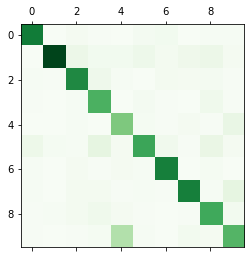

[[610   0  15   5   2  18  27   2   6   6]
 [  2 752  57  27  27  49  22  42  57  17]
 [  6   4 570  46   7   1  21  15  18   4]
 [  5   0   6 450   0  18   3   0  40   5]
 [  0   1   8   0 354  14   4  16   5  73]
 [ 50  12   9  90  16 487  36   5  70  15]
 [  8   1  17   4  16   9 597   2  14   0]
 [  6   2  21  23   4  11   3 598  10  86]
 [  5   7  21  41  16   5   1   4 473  24]
 [  3   1   4  12 240   9   1  24  16 434]]


In [69]:
values, test_duration = evaluator(X_val, y_val, log_reg_k)
print_eval(*values)

In [70]:
df = update_df(df, 'Logistic Regression', 'small dataset (k)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994                NaN   
                    test duration           0.416207                NaN   
                    accuracy                0.620571                NaN   
                    precision (macro)       0.612241                NaN   
                    recall (macro)          0.688935                NaN   
ANN                 train duration         28.467634                NaN   
                    test duration           0.644927                NaN   
                    accuracy                0.572571                NaN   
                    precision (macro)       0.565542                NaN   
                    recall (macro)          0.628459                NaN   
CNN                 train duration         28.467634                NaN   
                    test duration           0.644274                NaN   
                    accuracy                0.713714                NaN   
                    precision (macro)       0.709415                NaN   
                    recall (macro)          0.724838                NaN   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


#### SVM

In [71]:
svm_k = SVC()

start_time = time.time()
svm_k.fit(X_reps, y_reps)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Training time :0.008


Run time :0.439
Accuracy: 0.7332857142857143
Precision (macro): 0.7297984387150498
Recall (macro): 0.7676205229260088


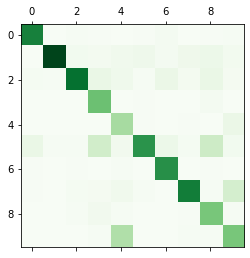

[[603   0  11   3   1   5  18   2   4   6]
 [  0 761  27  21  36  47  20  42  54  24]
 [ 14   7 649  68  40   6  65  22  66  16]
 [  1   0   2 394   0   3   0   0  18   2]
 [  0   0   2   0 270   4   1   3   2  60]
 [ 67  10  11 158  30 544  54  14 171  27]
 [  3   0   5   2  10   2 556   0   3   0]
 [  5   2  12  15  38   8   1 615  10 147]
 [  2   0   8  30   8   1   0   3 370  11]
 [  0   0   1   7 249   1   0   7  11 371]]


In [72]:
values, test_duration = evaluator(X_val, y_val, svm_k)
print_eval(*values)

In [73]:
df = update_df(df, 'SVM', 'small dataset (k)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634                NaN   
                    test duration           0.644927                NaN   
                    accuracy                0.572571                NaN   
                    precision (macro)       0.565542                NaN   
                    recall (macro)          0.628459                NaN   
CNN                 train duration         28.467634                NaN   
                    test duration           0.644274                NaN   
                    accuracy                0.713714                NaN   
                    precision (macro)       0.709415                NaN   
                    recall (macro)          0.724838                NaN   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


#### ANN

In [74]:
ann_k = build_reg_ann()

start_time = time.time()
history = ann_k.fit(X_reps, y_reps, epochs=30, 
                    callbacks = [stopping], validation_data=(X_val, y_val), batch_size = 32, verbose = True)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Epoch 1/30
2/2 [==============================] - 2s 1s/step - loss: 6.4803 - acc: 0.0536 - mae: 4.2250 - val_loss: 4.7132 - val_acc: 0.0729 - val_mae: 4.3566
Epoch 2/30
2/2 [==============================] - 1s 897ms/step - loss: 5.6008 - acc: 0.0714 - mae: 4.2250 - val_loss: 4.6004 - val_acc: 0.1144 - val_mae: 4.3566
Epoch 3/30
2/2 [==============================] - 1s 832ms/step - loss: 5.3764 - acc: 0.0893 - mae: 4.2250 - val_loss: 4.4892 - val_acc: 0.1461 - val_mae: 4.3566
Epoch 4/30
2/2 [==============================] - 1s 876ms/step - loss: 4.5756 - acc: 0.2321 - mae: 4.2250 - val_loss: 4.3767 - val_acc: 0.1706 - val_mae: 4.3566
Epoch 5/30
2/2 [==============================] - 1s 992ms/step - loss: 4.6587 - acc: 0.2143 - mae: 4.2250 - val_loss: 4.2611 - val_acc: 0.1910 - val_mae: 4.3566
Epoch 6/30
2/2 [==============================] - 1s 882ms/step - loss: 4.1384 - acc: 0.3571 - mae: 4.2250 - val_loss: 4.1341 - val_acc: 0.2209 - val_mae: 4.3566
Epoch 7/30
2/2 [===============

Run time :0.554
Accuracy: 0.7132857142857143
Precision (macro): 0.7069757458992021
Recall (macro): 0.7211725453871962


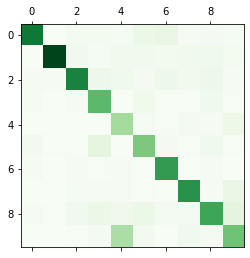

[[626   0  22  21  12  61  74   7  15  13]
 [  0 761  37  13  31  35  26  41  39  22]
 [  6   7 595  50  40  16  48  30  50   7]
 [  9   0   9 423   1  41   4   4  35   3]
 [  1   0   1   0 276  14   3  23   9  53]
 [ 25   3   4  95   1 362  15   3  37   5]
 [ 11   1   7   4  11   4 522   0   7   0]
 [  2   2  12  11   9   3   2 548  10  74]
 [ 14   4  38  62  43  61  19  18 491  98]
 [  1   2   3  19 258  24   2  34  16 389]]


In [75]:
values, test_duration = evaluator(X_val, y_val, ann_k, logits = True)
print_eval(*values)

In [76]:
df = update_df(df, 'ANN', 'small dataset (k)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634                NaN   
                    test duration           0.644274                NaN   
                    accuracy                0.713714                NaN   
                    precision (macro)       0.709415                NaN   
                    recall (macro)          0.724838                NaN   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


#### CNN

In [77]:
cnn_k = build_reg_cnn()

X_cnn_reps = np.array([x.reshape(28,28) for x in X_reps])
X_cnn_reps = np.expand_dims(X_cnn_reps,-1)

start_time = time.time()
history = cnn_k.fit(X_cnn_reps, y_reps, validation_data=(X_cnn_val, y_val), epochs=100, 
                    callbacks = [], batch_size = 32, verbose = True)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Epoch 1/100
2/2 [==============================] - 2s 1s/step - loss: 3.2373 - acc: 0.1429 - mae: 4.2250 - val_loss: 2.8016 - val_acc: 0.1251 - val_mae: 4.3566
Epoch 2/100
2/2 [==============================] - 1s 816ms/step - loss: 2.5617 - acc: 0.1964 - mae: 4.2250 - val_loss: 2.7961 - val_acc: 0.1011 - val_mae: 4.3566
Epoch 3/100
2/2 [==============================] - 1s 827ms/step - loss: 2.3924 - acc: 0.3571 - mae: 4.2250 - val_loss: 2.7929 - val_acc: 0.1021 - val_mae: 4.3566
Epoch 4/100
2/2 [==============================] - 1s 843ms/step - loss: 2.0860 - acc: 0.5000 - mae: 4.2250 - val_loss: 2.7939 - val_acc: 0.1646 - val_mae: 4.3566
Epoch 5/100
2/2 [==============================] - 1s 833ms/step - loss: 1.9078 - acc: 0.5714 - mae: 4.2250 - val_loss: 2.8012 - val_acc: 0.1891 - val_mae: 4.3566
Epoch 6/100
2/2 [==============================] - 1s 866ms/step - loss: 1.9021 - acc: 0.6071 - mae: 4.2250 - val_loss: 2.8141 - val_acc: 0.1433 - val_mae: 4.3566
Epoch 7/100
2/2 [========

Run time :0.664
Accuracy: 0.7941428571428572
Precision (macro): 0.7913631273755233
Recall (macro): 0.7979954306132286


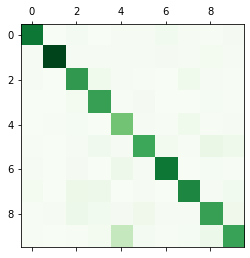

[[633   0  20   0   8  10  28   8   3  17]
 [  7 766   8   9   7  10  15   8  22   7]
 [  8   1 532  39   9   3   0  40  10   4]
 [  2   2  21 514   3  16   0   2  12   3]
 [  1   3  13   1 384   8   4  39   3   6]
 [  3   0   8  35   7 491  26   5  68  45]
 [ 11   0  15   0  50  11 633   0  13   5]
 [ 21   2  52  50   2   8   0 588  11  28]
 [  5   6  55  27  15  44   6   6 513  44]
 [  4   0   4  23 197  20   3  12  54 505]]


In [78]:
values, test_duration = evaluator(X_cnn_val, y_val, cnn_k, logits = True)
print_eval(*values)

In [79]:
df = update_df(df, 'CNN', 'small dataset (k)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


#### Comparison

As Geron suggests, we do see significant improvements over the original small dataset trained classifiers. However, the performance of these classifiers is significantly worse than that of the baseline k-means classifier.. 

### Label propagation (full)

Geron also suggests propagating class labels to expand the training set. We will try this here.

In [80]:
y_classes = np.argmin(kmeans.transform(X_train),axis = 1)
print(y_classes[0:5])

[27 21  3 25 55]


In [81]:
y_expanded = []

for i in range(len(y_classes)):
    y_expanded.append(y_reps[y_classes[i]])
y_expanded = np.array(y_expanded)    
print(y_expanded[:5])

[4 7 6 1 5]


#### logistic regression

In [82]:
log_reg_full = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=1, max_iter = 1000)

start_time = time.time()
log_reg_full.fit(X_train, y_expanded)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Training time :566.136


Run time :0.070
Accuracy: 0.7992857142857143
Precision (macro): 0.7958373151428602
Recall (macro): 0.8053591198006907


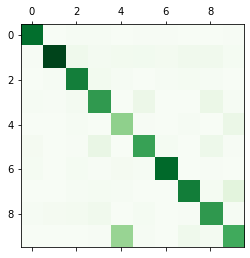

[[648   0  10   6   0   4   4   2   1   4]
 [  4 750  41  20  26  27  22  33  34  14]
 [  1   6 602  26   7   2   7  13   6   0]
 [  6   3  19 519   1  57   0   1  59   6]
 [  1   0   6   0 318   5   2   9   2  61]
 [ 16   2   5  72   2 498  14   2  48   3]
 [ 12   0  12   3  16   8 663   0   4   0]
 [  1   1   9  13  11   2   0 605  14 100]
 [  6  17  23  34   0  12   1   3 523   7]
 [  0   1   1   5 301   6   2  40  18 469]]


In [83]:
values, test_duration= evaluator(X_val, y_val, log_reg_full)
print_eval(*values)

In [84]:
df = update_df(df, 'Logistic Regression', 'propagation (full)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


#### SVM

In [85]:
svm_full = SVC()

start_time = time.time()
svm_full.fit(X_train, y_expanded)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Training time :258.170


Run time :110.492
Accuracy: 0.8252857142857143
Precision (macro): 0.8217388477556812
Recall (macro): 0.8301292609645268


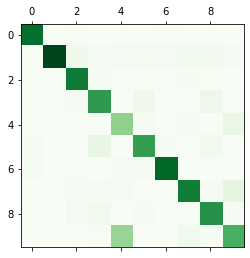

[[659   0   6   2   1   1   4   0   2   2]
 [  3 770  48  13  20  22  16  30  26  11]
 [  1   1 630  14   5   1   1  12   3   0]
 [  2   5   9 534   0  45   0   0  50   6]
 [  1   0   3   0 326   7   1   7   3  69]
 [ 12   0   0  80   1 523  11   0  41   2]
 [ 14   0   4   2  12   7 681   0   1   0]
 [  0   2  10   9   9   1   0 624  11  97]
 [  3   1  17  40   0  12   0   1 561   8]
 [  0   1   1   4 308   2   1  34  11 469]]


In [86]:
values, test_duration = evaluator(X_val, y_val, svm_full)
print_eval(*values)

In [87]:
df = update_df(df, 'SVM', 'propagation (full)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


#### ANN

In [88]:
ann_full = build_ann()

start_time = time.time()
history = ann_full.fit(X_train, y_expanded, epochs=30, 
                    callbacks = [stopping], validation_data=(X_val, y_val), batch_size = 32, verbose = True)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))


Epoch 1/30
1750/1750 [==============================] - 19s 10ms/step - loss: 0.4822 - acc: 0.8502 - mae: 4.4010 - val_loss: 0.7015 - val_acc: 0.8240 - val_mae: 4.3566
Epoch 2/30
1750/1750 [==============================] - 17s 10ms/step - loss: 0.3502 - acc: 0.8930 - mae: 4.4010 - val_loss: 0.7875 - val_acc: 0.8130 - val_mae: 4.3566
Epoch 3/30
1750/1750 [==============================] - 18s 10ms/step - loss: 0.3256 - acc: 0.9015 - mae: 4.4010 - val_loss: 0.7927 - val_acc: 0.8204 - val_mae: 4.3566
Epoch 4/30
1750/1750 [==============================] - 18s 10ms/step - loss: 0.3122 - acc: 0.9090 - mae: 4.4010 - val_loss: 0.8096 - val_acc: 0.8237 - val_mae: 4.3566
Epoch 5/30
1750/1750 [==============================] - 17s 10ms/step - loss: 0.2993 - acc: 0.9134 - mae: 4.4010 - val_loss: 0.8480 - val_acc: 0.8153 - val_mae: 4.3566
Epoch 6/30
1750/1750 [==============================] - 17s 10ms/step - loss: 0.2948 - acc: 0.9149 - mae: 4.4010 - val_loss: 0.8406 - val_acc: 0.8233 - val_mae:

Run time :0.507
Accuracy: 0.8232857142857143
Precision (macro): 0.8194949782929861
Recall (macro): 0.8265757725002505


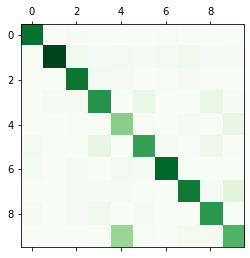

[[652   0   6   2   0   1   3   0   0   4]
 [  2 767  40   9  16  14  15  33  14  12]
 [  1   2 640  21   6   1   3  11   5   0]
 [  2   7   8 554   0  65   1   0  67   9]
 [  0   0   4   0 334   4   2   8   3  74]
 [ 20   1   0  71   1 514  10   3  44   3]
 [ 12   0  11   2  16   9 680   0   2   1]
 [  0   1   7   6   6   3   0 629  16 104]
 [  6   1  11  30   0   6   0   1 541   5]
 [  0   1   1   3 303   4   1  23  17 452]]


In [89]:
values, test_duration = evaluator(X_val, y_val, ann_full, logits = True)
print_eval(*values)

In [90]:
df = update_df(df, 'ANN', 'propagation (full)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


#### CNN

In [91]:
cnn_full = build_cnn()

start_time = time.time()
history = cnn_full.fit(X_cnn_train, y_expanded, validation_data=(X_cnn_val, y_val), epochs = 30, 
                    callbacks = [stopping], batch_size = 32, verbose = True)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Epoch 1/30
1750/1750 [==============================] - 15s 8ms/step - loss: 0.4426 - acc: 0.8652 - mae: 4.4010 - val_loss: 0.5838 - val_acc: 0.8454 - val_mae: 4.3566
Epoch 2/30
1750/1750 [==============================] - 14s 8ms/step - loss: 0.3024 - acc: 0.9037 - mae: 4.4010 - val_loss: 0.7310 - val_acc: 0.8083 - val_mae: 4.3566
Epoch 3/30
1750/1750 [==============================] - 14s 8ms/step - loss: 0.2617 - acc: 0.9144 - mae: 4.4010 - val_loss: 0.7260 - val_acc: 0.8243 - val_mae: 4.3566
Epoch 4/30
1750/1750 [==============================] - 14s 8ms/step - loss: 0.2378 - acc: 0.9208 - mae: 4.4010 - val_loss: 0.7576 - val_acc: 0.8156 - val_mae: 4.3566
Epoch 5/30
1750/1750 [==============================] - 14s 8ms/step - loss: 0.2178 - acc: 0.9261 - mae: 4.4010 - val_loss: 0.8547 - val_acc: 0.8203 - val_mae: 4.3566
Epoch 6/30
1750/1750 [==============================] - 14s 8ms/step - loss: 0.1985 - acc: 0.9322 - mae: 4.4010 - val_loss: 0.8501 - val_acc: 0.8166 - val_mae: 4.356

Run time :0.575
Accuracy: 0.8165714285714286
Precision (macro): 0.8130145549020165
Recall (macro): 0.8222982971972733


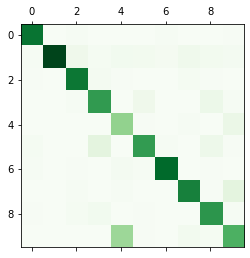

[[648   0   9   1   1   1   9   1   0   4]
 [  9 769  45  14  28  25  17  41  26  19]
 [  4   2 637  20   6   2   0  14   6   0]
 [  3   3   7 529   3  43   1   1  55   8]
 [  1   1   1   0 320   6   1  11   1  63]
 [ 14   0   0  99   2 527  10   0  51   5]
 [ 12   0   4   1  19   8 676   1   5   2]
 [  0   2   9   3   8   0   0 609   6  99]
 [  4   1  15  28   0   4   0   3 544   7]
 [  0   2   1   3 295   5   1  27  15 457]]


In [92]:
values, test_duration = evaluator(X_cnn_val, y_val, cnn_full, logits = True)
print_eval(*values)

In [93]:
df = update_df(df, 'CNN', 'propagation (full)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


#### Comparison

This provides a performance boost to all classifiers. Logistic regression remains slightly worse than baseline k-means, with all others being slightly better. Interestingly, CNN receives the smallest performance boost, and is slightly worse than ANN and SVM.

### Label propagation (top 20%)

Geron suggests propagating labels to only top 20% closest to the centroids. This results in a training set smaller than the full set, but significantly larger than 56. We try this here.

In [94]:
cutoff_percent = 20

def top_p(X, y, kmeans, p):
    distances = kmeans.transform(X)
    cluster_distances = distances[np.arange(len(X)), kmeans.labels_]
    for i in range(kmeans.get_params()['n_clusters']):
        i_mask = (kmeans.labels_ == i)
        i_distances = cluster_distances[i_mask]
        cutoff_distance = np.percentile(i_distances, p)
        cutoff_mask = (cluster_distances > cutoff_distance)
        cluster_distances[i_mask & cutoff_mask] = -1

    prop_mask = (cluster_distances != -1)
    return X[prop_mask], y[prop_mask]
    

    
X_train_top, y_train_top = top_p(X_train, y_expanded, kmeans, cutoff_percent)
print(X_train_top.shape)
print(y_train_top.shape)

(11222, 784)
(11222,)


#### Logistic regression

In [95]:
log_reg_20 = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=1, max_iter = 1000)

start_time = time.time()
log_reg_20.fit(X_train_top, y_train_top)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Training time :67.427


Run time :0.051
Accuracy: 0.7807142857142857
Precision (macro): 0.7784697533801312
Recall (macro): 0.7823645729190062


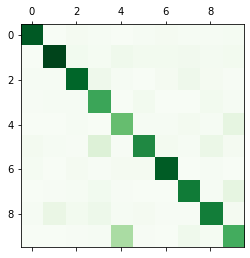

[[643   0  15   8   2   8  14   7   6  12]
 [  0 689  26  12  36  23  22  27  18  23]
 [  7   7 616  41   7   2  14  41  14   4]
 [  4   8   9 445   2  24   0   1  23   6]
 [  0   1  10   1 367   8   6  19   6  80]
 [ 21   7   4 109   3 524  19   9  55  14]
 [ 11   1  14   5  15  14 636   1   9   0]
 [  1   4   7  26   5   1   0 562   9  83]
 [  8  62  23  44   8  14   3   4 556  15]
 [  0   1   4   7 237   3   1  37  13 427]]


In [96]:
values, test_duration = evaluator(X_val, y_val, log_reg_20)
print_eval(*values)

In [97]:
df = update_df(df, 'Logistic Regression', 'propagation (20%)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


#### SVM

In [98]:
svm_20 = SVC()

start_time = time.time()
svm_20.fit(X_train_top, y_train_top)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Training time :10.778


Run time :20.495
Accuracy: 0.8192857142857143
Precision (macro): 0.8164448599604516
Recall (macro): 0.8194436453960433


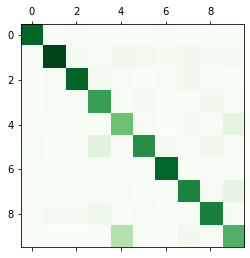

[[659   0   7   3   1   1   7   3   3   5]
 [  0 738  22  13  42  24  22  34  17  18]
 [  5   6 661  28  12   3  12  40  10   2]
 [  3  10   9 495   1  28   0   2  29   8]
 [  0   1   3   0 381   5   2  15   4  92]
 [ 12   3   2 101   0 543  15   6  39   6]
 [  9   0   4   3  11   6 657   0   5   0]
 [  0   2   4   5   3   0   0 576   6  86]
 [  7  18  15  46   3  11   0   2 588  10]
 [  0   2   1   4 228   0   0  30   8 437]]


In [99]:
values, test_duration = evaluator(X_val, y_val, svm_20)
print_eval(*values)

In [100]:
df = update_df(df, 'SVM', 'propagation (20%)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


#### ANN

In [101]:
ann_20 = build_ann()

start_time = time.time()
history = ann_20.fit(X_train_top, y_train_top, epochs=30, 
                    callbacks = [stopping], validation_data=(X_val, y_val), batch_size = 32, verbose = True)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Epoch 1/30
351/351 [==============================] - 6s 14ms/step - loss: 0.3498 - acc: 0.9038 - mae: 4.4002 - val_loss: 0.8725 - val_acc: 0.7963 - val_mae: 4.3566
Epoch 2/30
351/351 [==============================] - 5s 13ms/step - loss: 0.1350 - acc: 0.9690 - mae: 4.4002 - val_loss: 0.9760 - val_acc: 0.7936 - val_mae: 4.3566
Epoch 3/30
351/351 [==============================] - 4s 13ms/step - loss: 0.1201 - acc: 0.9742 - mae: 4.4002 - val_loss: 1.0074 - val_acc: 0.7947 - val_mae: 4.3566
Epoch 4/30
351/351 [==============================] - 5s 13ms/step - loss: 0.1020 - acc: 0.9785 - mae: 4.4002 - val_loss: 1.1685 - val_acc: 0.7851 - val_mae: 4.3566
Epoch 5/30
351/351 [==============================] - 5s 14ms/step - loss: 0.0946 - acc: 0.9811 - mae: 4.4002 - val_loss: 1.1467 - val_acc: 0.7850 - val_mae: 4.3566
Epoch 6/30
351/351 [==============================] - 5s 13ms/step - loss: 0.0904 - acc: 0.9836 - mae: 4.4002 - val_loss: 1.0953 - val_acc: 0.7927 - val_mae: 4.3566
Training t

Run time :0.541
Accuracy: 0.7927142857142857
Precision (macro): 0.7899273335732895
Recall (macro): 0.7939498652683521


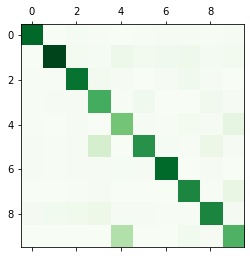

[[649   0  12   4   1   5   8   9   5  11]
 [  0 731  21  12  46  25  34  44  19  24]
 [  3   3 618  24   8   2   8  36   7   0]
 [  3   8   7 451   3  32   1   0  30  11]
 [  3   1  10   0 365   8   3  21   7  86]
 [ 11   3   7 140   0 529  12   4  57   7]
 [ 10   3  10   6  14   9 645   0   7   1]
 [  1   2   5   9   1   0   0 563   4  76]
 [ 15  28  38  50  11  10   3   4 566  16]
 [  0   1   0   2 233   1   1  27   7 432]]


In [102]:
values, test_duration = evaluator(X_val, y_val, ann_20, logits = True)
print_eval(*values)

In [103]:
df = update_df(df, 'ANN', 'propagation (20%)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


#### CNN

In [104]:
X_cnn_top = np.array([x.reshape(28,28) for x in X_train_top])
X_cnn_top = np.expand_dims(X_cnn_top,-1)

In [105]:
cnn_20 = build_cnn()

start_time = time.time()
history = cnn_20.fit(X_cnn_top, y_train_top, validation_data=(X_cnn_val, y_val), epochs = 30, 
                    callbacks = [stopping], batch_size = 32, verbose = True)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Epoch 1/30
351/351 [==============================] - 4s 11ms/step - loss: 0.3411 - acc: 0.9055 - mae: 4.4002 - val_loss: 0.7351 - val_acc: 0.8177 - val_mae: 4.3566
Epoch 2/30
351/351 [==============================] - 4s 11ms/step - loss: 0.1172 - acc: 0.9723 - mae: 4.4002 - val_loss: 0.9306 - val_acc: 0.7990 - val_mae: 4.3566
Epoch 3/30
351/351 [==============================] - 4s 10ms/step - loss: 0.0889 - acc: 0.9820 - mae: 4.4002 - val_loss: 0.8948 - val_acc: 0.8157 - val_mae: 4.3566
Epoch 4/30
351/351 [==============================] - 4s 10ms/step - loss: 0.0701 - acc: 0.9873 - mae: 4.4002 - val_loss: 1.0321 - val_acc: 0.8070 - val_mae: 4.3566
Epoch 5/30
351/351 [==============================] - 4s 10ms/step - loss: 0.0687 - acc: 0.9865 - mae: 4.4002 - val_loss: 0.9824 - val_acc: 0.8040 - val_mae: 4.3566
Epoch 6/30
351/351 [==============================] - 4s 11ms/step - loss: 0.0510 - acc: 0.9917 - mae: 4.4002 - val_loss: 1.0477 - val_acc: 0.8151 - val_mae: 4.3566
Training t

Run time :0.566
Accuracy: 0.8151428571428572
Precision (macro): 0.8126864261423636
Recall (macro): 0.8158898502700783


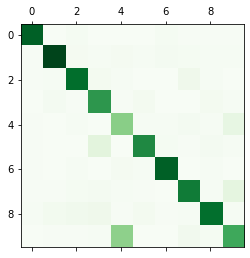

[[658   0  12   1   1   2  12   3   3   4]
 [  4 721  16   7  16   8  17  14   8   6]
 [  3   7 628  21  10   0   0  42   6   0]
 [  0  19   5 507   3  20   1   2  22   7]
 [  5   0  10   1 316  10   8  17   6  77]
 [  4   0   0  96   1 549  12   3  17   9]
 [  5   0   8   0  15   6 658   0   6   2]
 [  4   3  12  17   6   4   0 587   6  90]
 [ 11  25  34  40   5  20   5  10 623  10]
 [  1   5   3   8 309   2   2  30  12 459]]


In [106]:
values, test_duration = evaluator(X_cnn_val, y_val, cnn_20, logits = True)
print_eval(*values)

In [107]:
df = update_df(df, 'CNN', 'propagation (20%)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


### Label propagation (top 80%)

We reapeat the above using the top 80% in place of the top 20%.

In [108]:
cutoff_percent = 80
X_train_top, y_train_top = top_p(X_train, y_expanded, kmeans, cutoff_percent)
print(X_train_top.shape)
print(y_train_top.shape)

(44792, 784)
(44792,)


#### Logistic regression

In [109]:
log_reg_80 = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=1, max_iter = 1000)

start_time = time.time()
log_reg_80.fit(X_train_top, y_train_top)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Training time :445.286


Run time :0.053
Accuracy: 0.7961428571428572
Precision (macro): 0.7932895801233244
Recall (macro): 0.7978580478217305


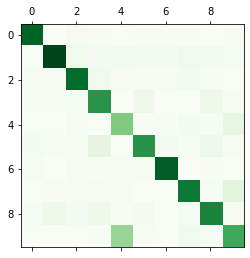

[[640   0   7   4   0   3   5   5   2   5]
 [  2 712  38  14  27  23  18  29  23  12]
 [  7   6 621  32  10   4  11  19   5   0]
 [  4   5  12 509   1  46   0   1  45   6]
 [  1   1   7   0 332   4   4  18   6  76]
 [ 20   8   8  81   2 512  19   4  51   6]
 [  8   1   8   4  10  10 655   0   4   0]
 [  0   3   8   8   9   0   0 587   7  99]
 [ 13  42  19  42   5  16   2  12 555  10]
 [  0   2   0   4 286   3   1  33  11 450]]


In [110]:
values, test_duration = evaluator(X_val, y_val, log_reg_80)
print_eval(*values)

In [111]:
df = update_df(df, 'Logistic Regression', 'propagation (80%)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


#### SVM

In [112]:
svm_80 = SVC()

start_time = time.time()
svm_80.fit(X_train_top, y_train_top)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Training time :129.146


Run time :77.669
Accuracy: 0.829
Precision (macro): 0.8257773584746065
Recall (macro): 0.829342126208609


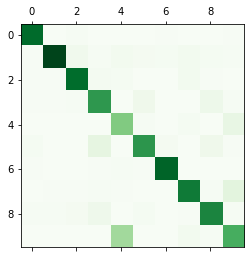

[[659   0   7   0   0   1   4   2   0   4]
 [  3 751  35   8  25  17  14  25  13   7]
 [  3   5 655  20  13   2   2  25   3   1]
 [  3   5   6 527   0  43   1   0  47   6]
 [  1   1   2   0 347   7   2  13   2  75]
 [ 13   2   2  86   1 533  16   1  44   3]
 [  5   1   2   3  11   5 676   1   1   0]
 [  0   3   3   8   5   0   0 614   8  98]
 [  8  10  16  45   2  13   0   3 581  10]
 [  0   2   0   1 278   0   0  24  10 460]]


In [113]:
values, test_duration = evaluator(X_val, y_val, svm_80)
print_eval(*values)

In [114]:
df = update_df(df, 'SVM', 'propagation (80%)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


#### ANN

In [115]:
ann_80 = build_ann()

start_time = time.time()
history = ann_80.fit(X_train_top, y_train_top, epochs=30, 
                    callbacks = [stopping], validation_data=(X_val, y_val), batch_size = 32, verbose = True)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Epoch 1/30
1400/1400 [==============================] - 17s 11ms/step - loss: 0.3875 - acc: 0.8823 - mae: 4.4011 - val_loss: 0.7180 - val_acc: 0.8159 - val_mae: 4.3566
Epoch 2/30
1400/1400 [==============================] - 16s 12ms/step - loss: 0.2496 - acc: 0.9286 - mae: 4.4011 - val_loss: 0.7419 - val_acc: 0.8239 - val_mae: 4.3566
Epoch 3/30
1400/1400 [==============================] - 16s 11ms/step - loss: 0.2269 - acc: 0.9363 - mae: 4.4011 - val_loss: 0.8361 - val_acc: 0.8157 - val_mae: 4.3566
Epoch 4/30
1400/1400 [==============================] - 16s 12ms/step - loss: 0.2137 - acc: 0.9423 - mae: 4.4011 - val_loss: 0.8198 - val_acc: 0.8196 - val_mae: 4.3566
Epoch 5/30
1400/1400 [==============================] - 16s 12ms/step - loss: 0.2076 - acc: 0.9438 - mae: 4.4011 - val_loss: 0.8506 - val_acc: 0.8173 - val_mae: 4.3566
Epoch 6/30
1400/1400 [==============================] - 16s 12ms/step - loss: 0.1958 - acc: 0.9497 - mae: 4.4011 - val_loss: 0.9053 - val_acc: 0.8170 - val_mae:

Run time :0.527
Accuracy: 0.8132857142857143
Precision (macro): 0.8103353929716197
Recall (macro): 0.8169136032962102


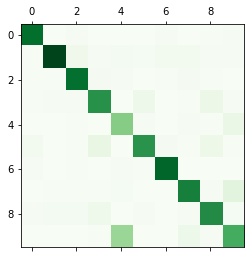

[[643   0   7   0   2   1   6   1   4   8]
 [  3 742  43  10  20  13  26  24  11   7]
 [  3   4 635  17  11   1   3  17   3   0]
 [  3   8  11 539   2  49   0   4  57  10]
 [  0   1   3   1 331   7   1   9   5  65]
 [ 24   1   3  76   0 532  15   4  50   4]
 [ 11   0   3   2  11   5 662   0   2   0]
 [  0   4   3   3  13   1   0 590   9  98]
 [  8  18  19  46   2  11   0   6 559  12]
 [  0   2   1   4 290   1   2  53   9 460]]


In [116]:
values, test_duration = evaluator(X_val, y_val, ann_80, logits = True)
print_eval(*values)

In [117]:
df = update_df(df, 'ANN', 'propagation (80%)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


#### CNN

In [118]:
X_cnn_top = np.array([x.reshape(28,28) for x in X_train_top])
X_cnn_top = np.expand_dims(X_cnn_top,-1)

In [119]:
cnn_80 = build_cnn()

start_time = time.time()
history = cnn_80.fit(X_cnn_top, y_train_top, validation_data=(X_cnn_val, y_val), epochs = 30, 
                    callbacks = [stopping], batch_size = 32, verbose = True)
train_duration = time.time() - start_time
print("Training time :{:.3f}".format(train_duration))

Epoch 1/30
1400/1400 [==============================] - 13s 9ms/step - loss: 0.3463 - acc: 0.8953 - mae: 4.4011 - val_loss: 0.6873 - val_acc: 0.8223 - val_mae: 4.3566
Epoch 2/30
1400/1400 [==============================] - 12s 9ms/step - loss: 0.2087 - acc: 0.9356 - mae: 4.4011 - val_loss: 0.7094 - val_acc: 0.8220 - val_mae: 4.3566
Epoch 3/30
1400/1400 [==============================] - 12s 9ms/step - loss: 0.1800 - acc: 0.9433 - mae: 4.4011 - val_loss: 0.6646 - val_acc: 0.8290 - val_mae: 4.3566
Epoch 4/30
1400/1400 [==============================] - 12s 9ms/step - loss: 0.1577 - acc: 0.9488 - mae: 4.4011 - val_loss: 0.7936 - val_acc: 0.8206 - val_mae: 4.3566
Epoch 5/30
1400/1400 [==============================] - 12s 9ms/step - loss: 0.1425 - acc: 0.9545 - mae: 4.4011 - val_loss: 0.7785 - val_acc: 0.8249 - val_mae: 4.3566
Epoch 6/30
1400/1400 [==============================] - 12s 9ms/step - loss: 0.1305 - acc: 0.9578 - mae: 4.4011 - val_loss: 0.8585 - val_acc: 0.8213 - val_mae: 4.356

Run time :1.148
Accuracy: 0.821
Precision (macro): 0.8176126583838546
Recall (macro): 0.8204212684451996


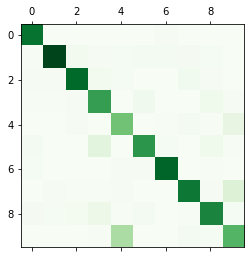

[[632   0   1   0   0   2   7   1   0   2]
 [  5 747  26   9  13  20  18  17  12   2]
 [  6   6 658  25  14   2   1  28   8   1]
 [  4   4   7 505   0  37   1   2  39   6]
 [  1   1   7   0 377   2   3  19   3  84]
 [ 18   1   1  97   0 529  13   2  38   4]
 [ 13   0   2   1  11   7 669   0   3   1]
 [  0   6   5   5   6   1   0 616  11 120]
 [ 16  13  21  52   3  20   2   3 583  13]
 [  0   2   0   4 258   1   1  20  12 431]]


In [120]:
values, test_duration = evaluator(X_cnn_val, y_val, cnn_80, logits = True)
print_eval(*values)

In [121]:
df = update_df(df, 'CNN', 'propagation (80%)', train_duration, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN                NaN   


### Voting ensembles 

#### No propagation

In [122]:
classifiers = [log_reg_k, svm_k]
ann_classifiers = [ann_k]
cnn_classifiers = [cnn_k]

start_time = time.time()
ensemble_predictions_val = classify(X_val, classifiers, ann_classifiers, cnn_classifiers)
train_duration = time.time() - start_time
print(ensemble_predictions_val[0:5])

[8 5 3 7 6]


Accuracy: 0.769
Precision (macro): 0.7654300548533967
Recall (macro): 0.778177832189684


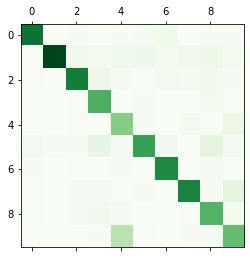

[[642   0  19   5   8  19  42   3   8   9]
 [  0 768  40  25  33  48  25  43  51  25]
 [  5   1 615  60  23   4  27  22  41   9]
 [  3   0   4 461   0  12   0   1  30   4]
 [  0   0   5   0 343  10   1  21   4  65]
 [ 29   6   9  86  12 510  36   2  98  18]
 [  6   1   5   2  12   4 583   0   6   0]
 [  5   2  15  17   5   7   1 601   8  97]
 [  5   1  15  33  16   3   0   4 449  26]
 [  0   1   1   9 230   4   0  11  14 411]]


In [123]:
values= []
values.append(accuracy_score(ensemble_predictions_val, y_val))
values.append(precision_score(ensemble_predictions_val, y_val, average = 'macro'))
values.append(recall_score(ensemble_predictions_val, y_val, average = 'macro'))
values.append(confusion_matrix(ensemble_predictions_val, y_val))

print(f'Accuracy: {values[0]}')
print(f'Precision (macro): {values[1]}')
print(f'Recall (macro): {values[2]}')
plt.matshow(values[3], cmap=plt.cm.Greens)
plt.show()
print(values[3])

In [124]:
df = update_df(df, 'Voting Ensemble', 'small dataset (k)', np.nan, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN           1.147689   


#### Top 20% propagation

In [125]:
classifiers = [log_reg_20, svm_20]
ann_classifiers = [ann_20]
cnn_classifiers = [cnn_20]

start_time = time.time()
ensemble_predictions_val = classify(X_val, classifiers, ann_classifiers, cnn_classifiers)
train_duration = time.time() - start_time
print(ensemble_predictions_val[0:5])

[9 5 3 7 6]


Accuracy: 0.8117142857142857
Precision (macro): 0.808992194450977
Recall (macro): 0.8109820356540165


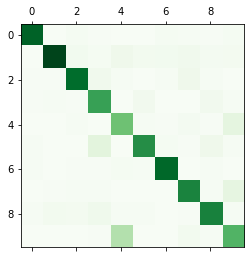

[[664   0  12   4   0   2  12   7   4  12]
 [  0 734  26  13  41  23  26  33  18  22]
 [  4   4 642  33   9   1   6  42  11   1]
 [  3   9   5 489   2  30   0   1  31   8]
 [  0   1   8   0 378   6   4  19   5  89]
 [  7   2   1 100   0 542  14   5  42   7]
 [ 10   0   4   4  13   8 653   0   6   0]
 [  0   3   6  11   2   0   0 573   8  84]
 [  7  25  22  40   6   9   0   4 577  11]
 [  0   2   2   4 231   0   0  24   7 430]]


In [126]:
values= []
values.append(accuracy_score(ensemble_predictions_val, y_val))
values.append(precision_score(ensemble_predictions_val, y_val, average = 'macro'))
values.append(recall_score(ensemble_predictions_val, y_val, average = 'macro'))
values.append(confusion_matrix(ensemble_predictions_val, y_val))

print(f'Accuracy: {values[0]}')
print(f'Precision (macro): {values[1]}')
print(f'Recall (macro): {values[2]}')
plt.matshow(values[3], cmap=plt.cm.Greens)
plt.show()
print(values[3])

In [127]:
df = update_df(df, 'Voting Ensemble', 'propagation (20%)', np.nan, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN           1.147689   


#### Top 80% propagation

In [128]:
classifiers = [log_reg_80, svm_80]
ann_classifiers = [ann_80]
cnn_classifiers = [cnn_80]

start_time = time.time()
ensemble_predictions_val = classify(X_val, classifiers, ann_classifiers, cnn_classifiers)
train_duration = time.time() - start_time
print(ensemble_predictions_val[0:5])

[9 5 3 7 6]


Accuracy: 0.8237142857142857
Precision (macro): 0.820482882378653
Recall (macro): 0.8242180535087325


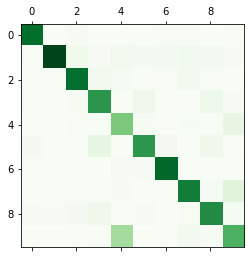

[[654   0   7   0   1   1   5   3   1   5]
 [  3 752  41   9  25  20  18  29  18   7]
 [  2   4 648  26  12   2   3  24   5   0]
 [  4   4   6 534   0  45   0   0  54   7]
 [  1   1   3   0 359   7   3  13   4  78]
 [ 15   2   1  76   0 531  17   2  43   3]
 [  5   0   2   2   7   6 669   0   2   0]
 [  0   4   4   5   6   0   0 608   9 105]
 [ 11  11  16  43   3   9   0   3 564  12]
 [  0   2   0   3 269   0   0  26   9 447]]


In [129]:
values= []
values.append(accuracy_score(ensemble_predictions_val, y_val))
values.append(precision_score(ensemble_predictions_val, y_val, average = 'macro'))
values.append(recall_score(ensemble_predictions_val, y_val, average = 'macro'))
values.append(confusion_matrix(ensemble_predictions_val, y_val))

print(f'Accuracy: {values[0]}')
print(f'Precision (macro): {values[1]}')
print(f'Recall (macro): {values[2]}')
plt.matshow(values[3], cmap=plt.cm.Greens)
plt.show()
print(values[3])

In [130]:
df = update_df(df, 'Voting Ensemble', 'propagation (80%)', np.nan, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN           1.147689   


#### Full propagation

In [132]:
classifiers = [log_reg_full, svm_full]
ann_classifiers = [ann_full]
cnn_classifiers = [cnn_full]

start_time = time.time()
ensemble_predictions_val = classify(X_val, classifiers, ann_classifiers, cnn_classifiers)
train_duration = time.time() - start_time
print(ensemble_predictions_val[0:5])

[9 5 3 7 6]


Accuracy: 0.8237142857142857
Precision (macro): 0.8201279073896991
Recall (macro): 0.8286346617992878


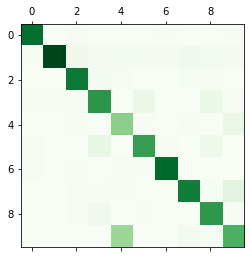

[[660   0   7   2   0   1   6   0   1   4]
 [  4 770  44  18  24  20  17  36  27  16]
 [  1   2 637  21   7   1   2  13   4   0]
 [  4   5  10 545   1  58   0   1  62   8]
 [  0   0   4   0 335   6   1   9   2  68]
 [ 11   0   0  71   1 522  11   0  46   3]
 [ 12   0   5   2  12   6 677   0   1   1]
 [  0   1   8   6   5   1   0 622  14 100]
 [  3   1  12  31   0   4   0   1 539   5]
 [  0   1   1   2 297   2   1  26  13 459]]


In [133]:
values= []
values.append(accuracy_score(ensemble_predictions_val, y_val))
values.append(precision_score(ensemble_predictions_val, y_val, average = 'macro'))
values.append(recall_score(ensemble_predictions_val, y_val, average = 'macro'))
values.append(confusion_matrix(ensemble_predictions_val, y_val))

print(f'Accuracy: {values[0]}')
print(f'Precision (macro): {values[1]}')
print(f'Recall (macro): {values[2]}')
plt.matshow(values[3], cmap=plt.cm.Greens)
plt.show()
print(values[3])

In [134]:
df = update_df(df, 'Voting Ensemble', 'propagation (full)', np.nan, test_duration, values, append_mode = False)
display(df)

baseline  k-preprocessing  \
classifier          metric                                           
Logistic Regression train duration     590.330607       401.086440   
                    test duration        0.073017         0.022987   
                    accuracy             0.916286         0.932143   
                    precision (macro)    0.915394         0.931166   
                    recall (macro)       0.915319         0.931286   
SVM                 train duration     270.056741        72.479812   
                    test duration       95.242315        18.094887   
                    accuracy             0.977286         0.958000   
                    precision (macro)    0.977033         0.957511   
                    recall (macro)       0.977215         0.957583   
ANN                 train duration     428.135511       198.802523   
                    test duration        0.664342         0.598537   
                    accuracy             0.975571         0.811143   
                    precision (macro)    0.975462         0.803821   
                    recall (macro)       0.975390         0.843989   
CNN                 train duration     131.675778              NaN   
                    test duration        0.589834              NaN   
                    accuracy             0.985429              NaN   
                    precision (macro)    0.985401              NaN   
                    recall (macro)       0.985276              NaN   
Voting Ensemble     train duration            NaN              NaN   
                    test duration       96.270254              NaN   
                    accuracy             0.980143              NaN   
                    precision (macro)    0.979816              NaN   
                    recall (macro)       0.980178              NaN   
K-means             train duration            NaN              NaN   
                    test duration             NaN              NaN   
                    accuracy                  NaN              NaN   
                    precision (macro)         NaN              NaN   
                    recall (macro)            NaN              NaN   

                                       small dataset  small dataset (k)  \
classifier          metric                                                
Logistic Regression train duration          0.187960           0.195045   
                    test duration           0.066587           0.068952   
                    accuracy                0.655286           0.760714   
                    precision (macro)       0.650495           0.757310   
                    recall (macro)          0.666250           0.768898   
SVM                 train duration          0.006994           0.007994   
                    test duration           0.416207           0.438692   
                    accuracy                0.620571           0.733286   
                    precision (macro)       0.612241           0.729798   
                    recall (macro)          0.688935           0.767621   
ANN                 train duration         28.467634          29.177878   
                    test duration           0.644927           0.553610   
                    accuracy                0.572571           0.713286   
                    precision (macro)       0.565542           0.706976   
                    recall (macro)          0.628459           0.721173   
CNN                 train duration         28.467634          90.525227   
                    test duration           0.644274           0.663532   
                    accuracy                0.713714           0.794143   
                    precision (macro)       0.709415           0.791363   
                    recall (macro)          0.724838           0.797995   
Voting Ensemble     train duration               NaN                NaN   
                    test duration                NaN           1.147689   


## Testing
Now we test the best performing models using the test data we set aside earlier.

In [159]:
columns = ['classifier', 'metric', 'baseline', 'small dataset', 'small dataset (k)', 'propagation (full)', 'propagation (80%)', 'propagation (20%)']
tests = pd.DataFrame(columns = columns)

In [160]:
values, test_duration = evaluator(X_test, y_test, log_reg_base)

tests = update_df(tests, 'Logistic Regression', 'baseline', np.nan, test_duration, values, training_time = False)

Run time :0.069


In [161]:
values, test_duration = evaluator(X_test, y_test, svm_base)

tests = update_df(tests, 'SVM', 'baseline', np.nan, test_duration, values, training_time = False)

Run time :93.952


In [162]:
values, test_duration = evaluator(X_test, y_test, ann_base, logits = True)

tests = update_df(tests, 'ANN', 'baseline', np.nan, test_duration, values, training_time = False)

Run time :0.493


In [163]:
values, test_duration = evaluator(X_cnn_test, y_test, cnn_base, logits = True)
tests = update_df(tests, 'CNN', 'baseline', np.nan, test_duration, values, training_time = False)

Run time :0.540


In [164]:
classifiers = [log_reg_base, svm_base]
ann_classifiers = [ann_base]
cnn_classifiers = [cnn_base]

start_time = time.time()
ensemble_predictions_test = classify(X_test, classifiers, ann_classifiers, cnn_classifiers)
test_duration = time.time() - start_time

values = []
values.append(accuracy_score(ensemble_predictions_test, y_test))
values.append(precision_score(ensemble_predictions_test, y_test, average = 'macro'))
values.append(recall_score(ensemble_predictions_test, y_test, average = 'macro'))
#values.append(confusion_matrix(ensemble_predictions_test, y_test))

tests = update_df(tests, 'Voting Ensemble', 'baseline', np.nan, test_duration, values, training_time = False)


In [165]:
start_time = time.time()
predicted_test_classes = np.argmin(kmeans.transform(X_test),axis = 1)
y_predictions = []

for i in range(len(predicted_test_classes)):
    y_predictions.append(y_reps[predicted_test_classes[i]])

test_duration = time.time() - start_time    
y_predictions = np.array(y_predictions) 

values = []
values.append(accuracy_score(y_predictions, y_test))
values.append(precision_score(y_predictions, y_test, average = 'macro'))
values.append(recall_score(y_predictions, y_test, average = 'macro'))
#values.append(confusion_matrix(y_predictions, y_test))

tests = update_df(tests, 'K-Means', 'small dataset (k)', np.nan, test_duration, values, training_time = False)

In [166]:
tests = tests.set_index(['classifier', 'metric'])

In [167]:
values, test_duration = evaluator(X_test, y_test, log_reg_small)

tests = update_df(tests, 'Logistic Regression', 'small dataset', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.063


In [168]:
values, test_duration = evaluator(X_test, y_test, svm_small)

tests = update_df(tests, 'SVM', 'small dataset', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.410


In [169]:
values, test_duration = evaluator(X_test, y_test, ann_small, logits = True)

tests = update_df(tests, 'ANN', 'small dataset', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.482


In [170]:
values, test_duration = evaluator(X_cnn_test, y_test, cnn_small, logits = True)

tests = update_df(tests, 'CNN', 'small dataset', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.493


In [171]:
values, test_duration = evaluator(X_test, y_test, log_reg_k)

tests = update_df(tests, 'Logistic Regression', 'small dataset (k)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.055


In [172]:
values, test_duration = evaluator(X_test, y_test, svm_k)

tests = update_df(tests, 'SVM', 'small dataset (k)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.399


In [173]:
values, test_duration = evaluator(X_test, y_test, ann_k, logits = True)

tests = update_df(tests, 'ANN', 'small dataset (k)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.512


In [174]:
values, test_duration = evaluator(X_cnn_test, y_test, cnn_k, logits = True)

tests = update_df(tests, 'CNN', 'small dataset (k)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.513


In [175]:
classifiers = [log_reg_k, svm_k]
ann_classifiers = [ann_k]
cnn_classifiers = [cnn_k]

start_time = time.time()
ensemble_predictions_test = classify(X_test, classifiers, ann_classifiers, cnn_classifiers)
test_duration = time.time() - start_time

values = []
values.append(accuracy_score(ensemble_predictions_test, y_test))
values.append(precision_score(ensemble_predictions_test, y_test, average = 'macro'))
values.append(recall_score(ensemble_predictions_test, y_test, average = 'macro'))
#values.append(confusion_matrix(ensemble_predictions_test, y_test))

tests = update_df(tests, 'Voting Ensemble', 'small dataset (k)', np.nan, test_duration, values, append_mode = False, training_time = False)


In [176]:
values, test_duration = evaluator(X_test, y_test, log_reg_full)

tests = update_df(tests, 'Logistic Regression', 'propagation (full)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.069


In [177]:
values, test_duration = evaluator(X_test, y_test, svm_full)

tests = update_df(tests, 'SVM', 'propagation (full)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :123.603


In [178]:
values, test_duration = evaluator(X_test, y_test, ann_full, logits = True)

tests = update_df(tests, 'ANN', 'propagation (full)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.508


In [179]:
values, test_duration = evaluator(X_cnn_test, y_test, cnn_full, logits = True)

tests = update_df(tests, 'CNN', 'propagation (full)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.506


In [180]:
classifiers = [log_reg_full, svm_full]
ann_classifiers = [ann_full]
cnn_classifiers = [cnn_full]

start_time = time.time()
ensemble_predictions_test = classify(X_test, classifiers, ann_classifiers, cnn_classifiers)
test_duration = time.time() - start_time

values = []
values.append(accuracy_score(ensemble_predictions_test, y_test))
values.append(precision_score(ensemble_predictions_test, y_test, average = 'macro'))
values.append(recall_score(ensemble_predictions_test, y_test, average = 'macro'))
#values.append(confusion_matrix(ensemble_predictions_test, y_test))

tests = update_df(tests, 'Voting Ensemble', 'propagation (full)', np.nan, test_duration, values, append_mode = False, training_time = False)


In [181]:
values, test_duration = evaluator(X_test, y_test, log_reg_20)

tests = update_df(tests, 'Logistic Regression', 'propagation (20%)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.073


In [182]:
values, test_duration = evaluator(X_test, y_test, svm_20)

tests = update_df(tests, 'SVM', 'propagation (20%)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :24.492


In [183]:
values, test_duration = evaluator(X_test, y_test, ann_20, logits = True)

tests = update_df(tests, 'ANN', 'propagation (20%)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.553


In [184]:
values, test_duration = evaluator(X_cnn_test, y_test, cnn_20, logits = True)

tests = update_df(tests, 'CNN', 'propagation (20%)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.645


In [185]:
classifiers = [log_reg_20, svm_20]
ann_classifiers = [ann_20]
cnn_classifiers = [cnn_20]

start_time = time.time()
ensemble_predictions_test = classify(X_test, classifiers, ann_classifiers, cnn_classifiers)
test_duration = time.time() - start_time

values = []
values.append(accuracy_score(ensemble_predictions_test, y_test))
values.append(precision_score(ensemble_predictions_test, y_test, average = 'macro'))
values.append(recall_score(ensemble_predictions_test, y_test, average = 'macro'))
#values.append(confusion_matrix(ensemble_predictions_test, y_test))

tests = update_df(tests, 'Voting Ensemble', 'propagation (20%)', np.nan, test_duration, values, append_mode = False, training_time = False)


In [186]:
values, test_duration = evaluator(X_test, y_test, log_reg_80)

tests = update_df(tests, 'Logistic Regression', 'propagation (80%)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.073


In [187]:
values, test_duration = evaluator(X_test, y_test, svm_80)

tests = update_df(tests, 'SVM', 'propagation (80%)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :83.384


In [188]:
values, test_duration = evaluator(X_test, y_test, ann_80, logits = True)

tests = update_df(tests, 'ANN', 'propagation (80%)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.471


In [189]:
values, test_duration = evaluator(X_cnn_test, y_test, cnn_80, logits = True)

tests = update_df(tests, 'CNN', 'propagation (80%)', np.nan, test_duration, values, append_mode=False, training_time = False)

Run time :0.504


In [190]:
classifiers = [log_reg_80, svm_80]
ann_classifiers = [ann_80]
cnn_classifiers = [cnn_80]

start_time = time.time()
ensemble_predictions_test = classify(X_test, classifiers, ann_classifiers, cnn_classifiers)
test_duration = time.time() - start_time

values = []
values.append(accuracy_score(ensemble_predictions_test, y_test))
values.append(precision_score(ensemble_predictions_test, y_test, average = 'macro'))
values.append(recall_score(ensemble_predictions_test, y_test, average = 'macro'))
#values.append(confusion_matrix(ensemble_predictions_test, y_test))

tests = update_df(tests, 'Voting Ensemble', 'propagation (80%)', np.nan, test_duration, values, append_mode = False, training_time = False)


In [191]:
display(tests)

baseline  small dataset  \
classifier          metric                                         
Logistic Regression test duration        0.068949       0.062501   
                    accuracy             0.920143       0.652429   
                    precision (macro)    0.918967       0.646088   
                    recall (macro)       0.918887       0.664106   
SVM                 test duration       93.952243       0.409989   
                    accuracy             0.975714       0.629429   
                    precision (macro)    0.975634       0.616234   
                    recall (macro)       0.975406       0.691059   
ANN                 test duration        0.492954       0.481654   
                    accuracy             0.975571       0.576571   
                    precision (macro)    0.975567       0.567691   
                    recall (macro)       0.975115       0.632351   
CNN                 test duration        0.540078       0.492525   
                    accuracy             0.986714       0.713000   
                    precision (macro)    0.986548       0.706228   
                    recall (macro)       0.986550       0.721565   
Voting Ensemble     test duration      106.652701            NaN   
                    accuracy             0.978429            NaN   
                    precision (macro)    0.978204            NaN   
                    recall (macro)       0.978207            NaN   
K-Means             test duration             NaN            NaN   
                    accuracy                  NaN            NaN   
                    precision (macro)         NaN            NaN   
                    recall (macro)            NaN            NaN   

                                       small dataset (k)  propagation (full)  \
classifier          metric                                                     
Logistic Regression test duration               0.054804            0.068951   
                    accuracy                    0.767000            0.800286   
                    precision (macro)           0.763320            0.796069   
                    recall (macro)              0.774675            0.806351   
SVM                 test duration               0.398660          123.602930   
                    accuracy                    0.737857            0.823143   
                    precision (macro)           0.733240            0.819479   
                    recall (macro)              0.774871            0.829056   
ANN                 test duration               0.512432            0.507503   
                    accuracy                    0.723714            0.821714   
                    precision (macro)           0.717237            0.817588   
                    recall (macro)              0.730228            0.825774   
CNN                 test duration               0.513366            0.506125   
                    accuracy                    0.799857            0.815000   
                    precision (macro)           0.796314            0.811628   
                    recall (macro)              0.800559            0.823138   
Voting Ensemble     test duration               1.772602          121.285488   
                    accuracy                    0.780429            0.820000   
                    precision (macro)           0.776377            0.815850   
                    recall (macro)              0.790199            0.826223   
K-Means             test duration               0.276083                 NaN   
                    accuracy                    0.810143                 NaN   
                    precision (macro)           0.806178                 NaN   
                    recall (macro)              0.816061                 NaN   

                                       propagation (80%)  propagation (20%)  
classifier          metric                                                   
Logistic Regression test duration  

The results from testing are broadly similar to the results using the validation set. As with the validation data, the best results using a small dataset with labels obtained using k-means come from SVM and the voting ensemble, with full or 80% propagation. This offers a small improvement over the baseline k-means classifier. It could be interesting to see if this holds more generally. This could be tested on the current dataset by using different random seeds and performing appropriate statistical significance tests on the various metrics, and also other datasets could be explored. I will not do that here though. 